Loading Data

In [1]:
# ---------------------------------------------------------------------
# NYC Yellow Taxi — Full Validation & Audit Pipeline for February 2025 Data
# ---------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns      
import os
import requests
from datetime import datetime, timedelta

# Load the trip data from a local Parquet file 
data_file_path = os.path.expanduser("~/Downloads/TripData/yellow_tripdata_2025-02.parquet")
df = pd.read_parquet(data_file_path)

# ensure df exists
try:
    df
except NameError:
    raise RuntimeError("Please load your dataframe into the variable `df` before running this cell.")

# copy to avoid modifying user's original reference
df = df.copy()
INITIAL_ROWS = len(df)
print(f"Initial loaded rows: {INITIAL_ROWS:,} (100.00%)\nInfo:\n")

df.info(show_counts=True)

Initial loaded rows: 3,577,543 (100.00%)
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577543 entries, 0 to 3577542
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               3577543 non-null  int32         
 1   tpep_pickup_datetime   3577543 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3577543 non-null  datetime64[us]
 3   passenger_count        2770606 non-null  float64       
 4   trip_distance          3577543 non-null  float64       
 5   RatecodeID             2770606 non-null  float64       
 6   store_and_fwd_flag     2770606 non-null  object        
 7   PULocationID           3577543 non-null  int32         
 8   DOLocationID           3577543 non-null  int32         
 9   payment_type           3577543 non-null  int64         
 10  fare_amount            3577543 non-null  float64       
 11  extra                  3577543 non-null  

CONFIGURABLE THRESHOLDS / ALLOWED VALUES

In [2]:
# --------- CONFIGURABLE THRESHOLDS / ALLOWED VALUES ----------
REPORTING_YEAR = 2025                       # Update as needed
REPORTING_MONTH = 2                         # Update as needed

OPENWEATHER_API_KEY = "YOUR_API_KEY_HERE"   # Replace with your actual API key (key after fetching de-activated)
lat, lon = 40.7580, -73.9855                # NYC coordinates (Times Square)

ALLOWED_VENDOR_IDS = {1, 2, 6, 7}
VENDOR_ID_NAMES = {1: "Creative Mobile Technologies, LLC", 2: "Curb Mobility, LLC",
                   6: "Myle Technologies Inc", 7: "Helix"}
MIN_DURATION_MIN = 1
MAX_DURATION_MIN = 300
MIN_PASSENGERS = 1
MAX_PASSENGERS = 5                          # NYC taxis have a max of 4 passengers (STD) 5 passengers (Van)
MIN_TRIP_DISTANCE = 0.1
MAX_TRIP_DISTANCE = 50                      # Long trips possible (e.g., to/from airports, other states)
ALLOWED_RATECODES = {1,2,3,4,5,6,99}
RATECODES_NAMES = {1: "Standard rate", 2: "JFK", 3: "Newark", 4: "Nassau or Westchester", 
                   5: "Negotiated fare", 6: "Group ride", 99: "Null/unknown"}
ALLOWED_STORE_AND_FWD = {"Y","N"}
ALLOWED_PAYMENT_TYPES = {0,1,2}
PAYMENT_TYPE_NAMES = {0: "Flex Fare trip", 1: "Credit card", 2: "Cash", 3: "No charge", 
                      4: "Dispute", 5: "Unknown", 6: "Voided trip"}
# NYC Taxi Fare Structure (as of June 2024)
# Source: https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
MIN_FARE = 3.50                             # Initial charge (up from $3.00)
METERED_RATE_PER_FIFTH_MILE = 0.70          # $0.70 per 1/5 mile when traveling above 12mph
METERED_RATE_PER_MINUTE = 0.70              # $0.70 per 60 seconds in slow traffic or when stopped
MAX_FARE = 10000

# Fare per mile validation bounds
# At normal speed: $0.70 * 5 = $3.50/mile
# In heavy traffic with waiting time: can be higher
FARE_PER_MILE_MIN = 2.0                     # Allow for distance-heavy trips
FARE_PER_MILE_MAX = 25.0                    # Allow for time-heavy trips (traffic/waiting)

MAX_TIP = 1000
MAX_TIP_TO_FARE_RATIO = 2.0
MAX_TOLL = 100.0
MAX_TOTAL_AMOUNT = 20000.0
MAX_TOLERANCE_TOTAL_AMOUNT = 2.0
ALLOWED_MTA = {0.0, 0.5}
ALLOWED_IMPROVEMENT_SURCHARGE = {0.0, 1.0}
ALLOWED_CONGESTION_SURCHARGE = {0.0, 2.50}
ALLOWED_CBD_CONGESTION_SURCHARGE = {0.0, 0.75}

# NYC Airport Location IDs
JFK_LOCATION_IDS = [132]
LGA_LOCATION_IDS = [138]
EWR_LOCATION_IDS = [1]

# JFK Flat Fare: $70.00 (excludes tolls, taxes, tip, surcharges)
# The fare_amount field should be $70.00 for flat fare trips
# Additional charges are in separate fields (mta_tax, improvement_surcharge, etc.)
JFK_MANHATTAN_FLAT_FARE_BASE = 70.00

# Airport fees
AIRPORT_ACCESS_FEE = 1.75
LGA_SURCHARGE = 5.0
EWR_SURCHARGE = 20.0                            # Not in Airport_fee field
LGA_TRIPS = AIRPORT_ACCESS_FEE + LGA_SURCHARGE  # $6.75
RUSH_HOUR_SURCHARGE_AIR = 5.0                   # Airport rush hour (4pm-8pm weekdays, excluding holidays)
ALLOWED_AIRPORT_FEES = [0.00, AIRPORT_ACCESS_FEE, LGA_SURCHARGE, RUSH_HOUR_SURCHARGE_AIR, LGA_TRIPS, AIRPORT_ACCESS_FEE + RUSH_HOUR_SURCHARGE_AIR]

# Standard trip surcharges (goes in 'extra' field)
OVERNIGHT_SURCHARGE = 1.0                       # 8pm-6am daily
RUSH_HOUR_SURCHARGE_STD = 2.5                   # 4pm-8pm weekdays (excluding holidays)
BOTH_SURCHARGES = OVERNIGHT_SURCHARGE + RUSH_HOUR_SURCHARGE_STD  # Rare overlap at 8pm
ALLOWED_EXTRA_VALUES = {0.0, OVERNIGHT_SURCHARGE, RUSH_HOUR_SURCHARGE_STD, BOTH_SURCHARGES}

# Federal holidays in February 2025 (for rush hour surcharge exemptions), reading excel file is avoided for simplicity
FEDERAL_HOLIDAYS_2025 = pd.to_datetime([
    "2025-01-01", "2025-01-20", "2025-02-17", "2025-05-26", "2025-06-19",
    "2025-07-04", "2025-09-01", "2025-10-13", "2025-11-04", "2025-11-11",
    "2025-11-27", "2025-12-25"
])
FEDERAL_HOLIDAYS_2025 = pd.to_datetime(FEDERAL_HOLIDAYS_2025)

MAX_DISPLAY_ROWS = 20  # max rows to show when printing unique values

Helper Functions

In [3]:
# --------- UTILITY FUNCTIONS FOR DATA QUALITY CHECKS ----------

def pct_str(count, total):
    """
    Return formatted string with count and percentage of flagged rows.
    
    Parameters:
    - count: Number of flagged rows
    - total: Total number of rows
    
    Returns:
    - Formatted string: "count (percentage%)"
    """
    if total > 0:
        percentage = (count / total * 100)
        return f"{count:<20,} ({percentage:>6.2f}%)"
    else:
        return f"{count:<20,} (  N/A%)"

def report_flag(flag_col):
    """
    Print formatted report of a flag column with aligned output.
    
    Parameters:
    - flag_col: Name of the boolean flag column in df
    """
    try:
        n = int(df[flag_col].sum())
        # Dynamic width: at least 40 chars, but expand if flag name is longer
        max_name_width = max(len(flag_col), 40)
        print(f"{flag_col:<{max_name_width}} : {pct_str(n, INITIAL_ROWS)} flagged")
    except KeyError:
        print(f"⚠️  Warning: Flag column '{flag_col}' does not exist in dataframe")
    except Exception as e:
        print(f"⚠️  Error reporting flag '{flag_col}': {str(e)}")

def create_flag(name, cond):
    """
    Create boolean column 'is_invalid_<name>' where True indicates invalid records.
    
    Parameters:
    - name: Suffix for the flag column name (e.g., 'VendorID' creates 'is_invalid_VendorID')
    - cond: Boolean Series where True = valid, False = invalid
    
    Returns:
    - col: Name of the created flag column
    
    Note: The function inverts the condition, so True in the flag means INVALID.
    """
    # Validate input
    if not isinstance(cond, pd.Series):
        raise TypeError(f"Condition must be a pandas Series, got {type(cond)}")
    
    if len(cond) != len(df):
        raise ValueError(f"Condition length ({len(cond)}) doesn't match dataframe length ({len(df)})")
    
    # Create flag column
    col = f"is_invalid_{name}"
    
    # Check if column already exists
    if col in df.columns:
        print(f"⚠️  Warning: Overwriting existing flag column '{col}'")
    
    df[col] = ~cond  # Invert: True in flag means invalid
    report_flag(col)
    return col

def print_unique_values(column_name, sort_by="count", sort="asc"):
    """
    Print overview of unique values in a DataFrame column with flexible sorting.

    Parameters:
    - column_name (str): Name of the column to analyze in df.
    - sort_by (str): 'count' to sort by frequency, 'value' to sort by unique values.
    - sort (str): 'asc' for ascending, 'desc' for descending sort order.
    """
    unique_values = df[column_name].unique()
    print(f"=== Unique {column_name} Values ===")

    has_nan = df[column_name].isna().any()
    non_nan_values = [v for v in unique_values if not pd.isna(v)]

    total_unique = len(non_nan_values) + (1 if has_nan else 0)

    if total_unique > MAX_DISPLAY_ROWS:
        print(f"  Total unique values: {total_unique} (showing top {MAX_DISPLAY_ROWS})")
        value_counts = df[column_name].value_counts(dropna=True)

        # Apply sorting based on parameters
        if sort_by == "count":
            value_counts = value_counts.sort_values(ascending=(sort == "asc")).head(MAX_DISPLAY_ROWS)
        elif sort_by == "value":
            try:
                # Try to sort indices (unique values)
                sorted_index = sorted(value_counts.index, reverse=(sort=="desc"))
                value_counts = value_counts.loc[sorted_index].head(MAX_DISPLAY_ROWS)
            except TypeError:
                # Mixed types fallback: sort as strings
                sorted_index = sorted(value_counts.index, key=str, reverse=(sort=="desc"))
                value_counts = value_counts.loc[sorted_index].head(MAX_DISPLAY_ROWS)

        for value, count in value_counts.items():
            print(f"  {value}: {count:,} rows")
    else:
        if sort_by == "count":
            value_counts = df[column_name].value_counts(dropna=True)
            value_counts = value_counts.sort_values(ascending=(sort == "asc"))
            for value, count in value_counts.items():
                print(f"  {value}: {count:,} rows")
        elif sort_by == "value":
            try:
                sorted_values = sorted(non_nan_values, reverse=(sort=="desc"))
            except TypeError:
                sorted_values = sorted(non_nan_values, key=str, reverse=(sort=="desc"))
            for value in sorted_values:
                count = df[df[column_name] == value].shape[0]
                print(f"  {value}: {count:,} rows")

    if has_nan:
        count = df[column_name].isna().sum()
        print(f"  NaN: {count:,} rows")

    print("*******************************************")

def fetch_weather_data_openweather_hourly(date, api_key):
    """
    Fetch historical weather data from OpenWeatherMap API for a specific date.
    Makes 24 separate API calls (one per hour) to get complete hourly data.
    
    Args:
        date: datetime.date object (unique day)
        api_key: OpenWeatherMap API key
    
    Returns:
        list of dicts, one per hour (24 records) or None if all requests fail
    """
    
    from datetime import datetime, timedelta
    
    hourly_records = []
    
    # Loop through all 24 hours of the day
    for hour in range(24):
        # Create datetime for this specific hour
        hour_dt = datetime.combine(date, datetime.min.time()) + timedelta(hours=hour)
        dt_timestamp = int(hour_dt.timestamp())
        
        # API endpoint for historical data
        url = "https://api.openweathermap.org/data/3.0/onecall/timemachine"
        
        params = {
            'lat': lat,
            'lon': lon,
            'dt': dt_timestamp,
            'appid': api_key,
            'units': 'metric',
            'lang': 'en'
        }
        
        try:
            response = requests.get(url, params=params, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                # ✅ Extract ALL available fields from API response
                if 'data' in data and len(data['data']) > 0:
                    hour_data = data['data'][0]  # First (and only) record for this timestamp
                    
                    record = {
                        # Timestamp fields
                        'date': date,
                        'datetime': hour_dt,
                        'hour': hour,
                        'dt': hour_data.get('dt'),  # Unix timestamp from API
                        
                        # Sun times (Unix timestamps)
                        'sunrise': hour_data.get('sunrise'),
                        'sunset': hour_data.get('sunset'),
                        
                        # Temperature (Celsius)
                        'temp': hour_data.get('temp', np.nan),
                        'feels_like': hour_data.get('feels_like', np.nan),
                        'dew_point': hour_data.get('dew_point', np.nan),
                        
                        # Atmospheric conditions
                        'pressure': hour_data.get('pressure', np.nan),  # hPa
                        'humidity': hour_data.get('humidity', np.nan),  # %
                        'clouds': hour_data.get('clouds', np.nan),  # %
                        'visibility': hour_data.get('visibility', 10000) / 1000.0,  # meters to km
                        
                        # Wind (convert m/s to km/h)
                        'wind_speed': hour_data.get('wind_speed', 0) * 3.6,  # m/s to km/h
                        'wind_deg': hour_data.get('wind_deg', np.nan),  # degrees
                        'wind_gust': hour_data.get('wind_gust', 0) * 3.6 if hour_data.get('wind_gust') else np.nan,  # m/s to km/h
                        
                        # Weather condition
                        'weather_id': hour_data.get('weather', [{}])[0].get('id', np.nan),
                        'weather_main': hour_data.get('weather', [{}])[0].get('main', 'Clear'),
                        'weather_description': hour_data.get('weather', [{}])[0].get('description', ''),
                        'weather_icon': hour_data.get('weather', [{}])[0].get('icon', ''),
                    }
                    
                    hourly_records.append(record)
                else:
                    print(f"\n    ⚠️  Hour {hour:02d}:00 - No data in API response")
            
            elif response.status_code == 401:
                print(f"\n    ❌ Authentication failed - check API key")
                return None  # Stop immediately on auth failure
            elif response.status_code == 429:
                print(f"\n    ⚠️  Rate limit exceeded - stopping")
                return hourly_records if hourly_records else None
            else:
                print(f"\n    ⚠️  Hour {hour:02d}:00 - API error {response.status_code}")
            
            # Rate limiting: 1.1 seconds between API calls
            # Free tier: 60 calls/min = 1 call per second
            if hour < 23:  # Don't wait after last hour
                import time
                time.sleep(1.1)
        
        except requests.exceptions.Timeout:
            print(f"\n    ⚠️  Hour {hour:02d}:00 - Request timeout")
        except requests.exceptions.ConnectionError:
            print(f"\n    ⚠️  Hour {hour:02d}:00 - Connection error")
        except Exception as e:
            print(f"\n    ⚠️  Hour {hour:02d}:00 - {str(e)}")
    
    # Return list of records (up to 24, one per hour)
    if len(hourly_records) > 0:
        return hourly_records
    else:
        return None

Vendor Validation

In [4]:
print("********* STARTING DATA QUALITY CHECKS *********\n")
# ---------- 1) VendorID ----------
print("1) VendorID checks")
print_unique_values('VendorID', sort_by='count', sort='desc')
cond_ven = df['VendorID'].isin(ALLOWED_VENDOR_IDS)  
create_flag("VendorID", cond_ven)
print()

********* STARTING DATA QUALITY CHECKS *********

1) VendorID checks
=== Unique VendorID Values ===
  2: 2,817,803 rows
  1: 754,990 rows
  7: 4,420 rows
  6: 330 rows
*******************************************
is_invalid_VendorID                      : 0                    (  0.00%) flagged



Datetime & Trip Duration Validation

In [5]:
# ---------- 2) Datetimes ----------
print("2) Datetime checks (pickup/dropoff) checks")
# convert to datetime, coerce errors -> NaT
df['tpep_pickup_datetime']  = pd.to_datetime(df.get('tpep_pickup_datetime'), errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df.get('tpep_dropoff_datetime'), errors='coerce')
# missing datetimes
create_flag("tpep_datetime_missing", df['tpep_pickup_datetime'].notna() & df['tpep_dropoff_datetime'].notna())
# swap where dropoff earlier than pickup (we will correct timestamps in-place and keep a flag)
mask_swapped = (df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime']) & df['tpep_pickup_datetime'].notna() & df['tpep_dropoff_datetime'].notna()
print(f"Rows with pickup/dropoff reversed (will swap timestamps): {pct_str(mask_swapped.sum(), INITIAL_ROWS)}")
# swap
df.loc[mask_swapped, ['tpep_pickup_datetime', 'tpep_dropoff_datetime']] = df.loc[mask_swapped, ['tpep_dropoff_datetime', 'tpep_pickup_datetime']].values
# flag swapped rows
df['is_swapped_pickup_dropoff'] = False
df.loc[mask_swapped, 'is_swapped_pickup_dropoff'] = True
report_flag('is_swapped_pickup_dropoff')
# filter to expected month if applicable (Feb 2025)
mask_month = df['tpep_dropoff_datetime'].dt.to_period('M') == pd.Period(f'{REPORTING_YEAR}-{REPORTING_MONTH:02d}')
create_flag("dropoff_not_feb2025", mask_month)
# duration
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0
cond_duration = df['trip_duration_min'].notna() & (df['trip_duration_min']>=MIN_DURATION_MIN) & (df['trip_duration_min']<=MAX_DURATION_MIN)
create_flag("trip_duration", cond_duration)

# print min pickup and max dropoff datetime
# print values and count of pickup previous month (January 2025)
# print values and count of drop off previous month (January 2025)
# print values and count of pickup next month (March 2025)
# print values and count of drop off next month (March 2025)

print() 

2) Datetime checks (pickup/dropoff) checks
is_invalid_tpep_datetime_missing         : 0                    (  0.00%) flagged
Rows with pickup/dropoff reversed (will swap timestamps): 93                   (  0.00%)
is_swapped_pickup_dropoff                : 93                   (  0.00%) flagged
is_invalid_dropoff_not_feb2025           : 2,406                (  0.07%) flagged
is_invalid_trip_duration                 : 41,391               (  1.16%) flagged



Passenger Count Validation

In [6]:
# ---------- 3) Passenger count ----------
print("3) Passenger count checks")
print_unique_values('passenger_count', sort_by='count', sort='desc')
cond_pass = df['passenger_count'].notna() & (df['passenger_count'].astype(float) >= MIN_PASSENGERS) & (df['passenger_count'].astype(float) <= MAX_PASSENGERS)
create_flag("passenger_count", cond_pass)
print()

3) Passenger count checks
=== Unique passenger_count Values ===
  1.0: 2,226,109 rows
  2.0: 370,813 rows
  3.0: 78,032 rows
  4.0: 46,625 rows
  0.0: 21,751 rows
  5.0: 16,648 rows
  6.0: 10,612 rows
  8.0: 9 rows
  7.0: 4 rows
  9.0: 3 rows
  NaN: 806,937 rows
*******************************************
is_invalid_passenger_count               : 839,316              ( 23.46%) flagged



Trip Distance Validation

In [7]:
# ---------- 4) Trip distance ----------
print("4) Trip distance checks")
print_unique_values('trip_distance', sort_by='count', sort='desc')
cond_dist = df['trip_distance'].notna() & (df['trip_distance'] >= MIN_TRIP_DISTANCE) & (df['trip_distance'] <= MAX_TRIP_DISTANCE)
create_flag("trip_distance", cond_dist)
# Optional: check correlation with fare_amount and distance
print()

4) Trip distance checks
=== Unique trip_distance Values ===
  Total unique values: 4365 (showing top 20)
  0.0: 99,771 rows
  0.9: 43,053 rows
  1.0: 42,500 rows
  0.8: 42,304 rows
  1.1: 41,181 rows
  1.2: 39,973 rows
  0.7: 39,177 rows
  1.3: 38,018 rows
  1.4: 35,611 rows
  0.6: 34,358 rows
  1.5: 33,864 rows
  1.6: 31,947 rows
  1.7: 30,215 rows
  1.8: 27,621 rows
  0.5: 26,852 rows
  1.9: 25,812 rows
  2.0: 23,745 rows
  2.1: 21,949 rows
  2.2: 20,206 rows
  0.4: 18,531 rows
*******************************************
is_invalid_trip_distance                 : 125,246              (  3.50%) flagged



Rate Code Validation

In [8]:
# ---------- 5) RatecodeID ----------
print("5) RatecodeID checks")
print_unique_values('RatecodeID', sort_by='count', sort='desc')
cond_ratecode = df['RatecodeID'].notna() & df['RatecodeID'].isin(ALLOWED_RATECODES)
create_flag("RatecodeID", cond_ratecode)
print()

5) RatecodeID checks
=== Unique RatecodeID Values ===
  1.0: 2,612,715 rows
  2.0: 81,895 rows
  99.0: 39,132 rows
  5.0: 22,523 rows
  3.0: 7,951 rows
  4.0: 6,389 rows
  6.0: 1 rows
  NaN: 806,937 rows
*******************************************
is_invalid_RatecodeID                    : 806,937              ( 22.56%) flagged



Store and Forward Flag Validation

In [9]:
# ---------- 6) store_and_fwd_flag ----------
print("6) store_and_fwd_flag")
print_unique_values('store_and_fwd_flag', sort_by='count', sort='desc')
cond_store_and_fwd = df['store_and_fwd_flag'].notna() & df['store_and_fwd_flag'].isin(ALLOWED_STORE_AND_FWD)
create_flag("store_and_fwd_flag", cond_store_and_fwd)
print()

6) store_and_fwd_flag
=== Unique store_and_fwd_flag Values ===
  N: 2,742,663 rows
  Y: 27,943 rows
  NaN: 806,937 rows
*******************************************
is_invalid_store_and_fwd_flag            : 806,937              ( 22.56%) flagged



Location ID Validation

In [10]:
# ---------- 7) PULocationID / DOLocationID ----------
print("7) PULocationID & DOLocationID")
# make sure integer-ish and in 1..265
cond_pu = df['PULocationID'].notna() & (df['PULocationID'].between(1,265))
cond_do = df['DOLocationID'].notna() & (df['DOLocationID'].between(1,265))
create_flag("PULocationID", cond_pu)
create_flag("DOLocationID", cond_do)
# Optional: check if trip is within same zone & long trip (possible anomaly)
mask_same_zone_long = (df['PULocationID'] == df['DOLocationID']) & (df['trip_duration_min'] > 60)
df['is_same_zone_long_trip'] = mask_same_zone_long
report_flag('is_same_zone_long_trip')
print()

7) PULocationID & DOLocationID
is_invalid_PULocationID                  : 0                    (  0.00%) flagged
is_invalid_DOLocationID                  : 0                    (  0.00%) flagged
is_same_zone_long_trip                   : 339                  (  0.01%) flagged



Payment Type Validation

In [11]:
# ---------- 8) payment_type ----------
print("8) payment_type")
print_unique_values('payment_type', sort_by='count', sort='desc')
cond_payment_type = df['payment_type'].notna() & df['payment_type'].isin(ALLOWED_PAYMENT_TYPES)
create_flag("payment_type", cond_payment_type)  
print()

8) payment_type
=== Unique payment_type Values ===
  1: 2,336,175 rows
  0: 806,937 rows
  2: 339,481 rows
  4: 73,101 rows
  3: 21,849 rows
*******************************************
is_invalid_payment_type                  : 94,950               (  2.65%) flagged



Fare Amount Validation

In [12]:
# ---------- 9) fare_amount (enhanced checks) ----------
print("9) fare_amount and fare-per-mile checks")
print_unique_values('fare_amount', sort_by='count', sort='desc')

# Basic domain validation: fare must be within valid range
cond_fare_basic = df['fare_amount'].notna() & (df['fare_amount'] >= MIN_FARE) & (df['fare_amount'] <= MAX_FARE)
create_flag("fare_amount", cond_fare_basic)

# Flag negative fares
df['is_fare_negative'] = pd.to_numeric(df['fare_amount'], errors='coerce') < 0
report_flag('is_fare_negative')

# Flag zero fares
df['is_fare_zero'] = df['fare_amount'] == 0
report_flag('is_fare_zero')

# Cross-validation: Check JFK flat fare consistency
# RatecodeID=2 should have $70 fare (base, before tolls/taxes)
is_jfk_flat_fare = (df['RatecodeID'] == 2)
df['is_jfk_flat_fare_incorrect'] = is_jfk_flat_fare & (df['fare_amount'] != JFK_MANHATTAN_FLAT_FARE_BASE)
report_flag('is_jfk_flat_fare_incorrect')

# Cross-validation: Minimum fare check
# All standard rate trips should respect $3.50 minimum
is_standard_rate = (df['RatecodeID'] == 1)
df['is_fare_below_minimum'] = is_standard_rate & (df['fare_amount'] < MIN_FARE) & (df['fare_amount'] > 0)
report_flag('is_fare_below_minimum')

# Fare per mile validation: detect extreme rates
df['fare_per_mile'] = np.where(
    df['trip_distance'] > 0.1,
    df['fare_amount'] / df['trip_distance'], 
    np.nan
)

# Flag extreme fare-per-mile values
# Note: Higher values are acceptable due to waiting time charges
cond_fpm = (
    df['fare_per_mile'].isna() |
    ((df['fare_per_mile'] >= FARE_PER_MILE_MIN) & (df['fare_per_mile'] <= FARE_PER_MILE_MAX))
)
create_flag("fare_per_mile", cond_fpm)

df['is_fare_per_mile_too_low'] = (df['fare_per_mile'].notna()) & (df['fare_per_mile'] < FARE_PER_MILE_MIN)
df['is_fare_per_mile_too_high'] = (df['fare_per_mile'].notna()) & (df['fare_per_mile'] > FARE_PER_MILE_MAX)
report_flag('is_fare_per_mile_too_low')
report_flag('is_fare_per_mile_too_high')

# Fare vs distance relationship
df['is_long_trip_low_fare'] = (df['trip_distance'] > 20) & (df['fare_amount'] < 50)
df['is_short_trip_high_fare'] = (df['trip_distance'] < 1) & (df['fare_amount'] > 100)
report_flag('is_long_trip_low_fare')
report_flag('is_short_trip_high_fare')

# Fare per minute validation (accounts for waiting time)
df['fare_per_minute'] = np.where(
    df['trip_duration_min'] > 1,
    df['fare_amount'] / df['trip_duration_min'],
    np.nan
)

# NYC waiting time: $0.70 per 60 seconds = $0.70/minute
# Reasonable range: $0.05/min (fast highway) to $10/min (heavy traffic)
df['is_fare_per_minute_too_low'] = (df['fare_per_minute'].notna()) & (df['fare_per_minute'] < 0.05)
df['is_fare_per_minute_too_high'] = (df['fare_per_minute'].notna()) & (df['fare_per_minute'] > 10.0)
report_flag('is_fare_per_minute_too_low')
report_flag('is_fare_per_minute_too_high')

# Payment type consistency
df['is_no_charge_with_fare'] = (df['payment_type'] == 3) & (df['fare_amount'] > 0)
df['is_voided_with_fare'] = (df['payment_type'] == 6) & (df['fare_amount'] > 0)
report_flag('is_no_charge_with_fare')
report_flag('is_voided_with_fare')

# Statistical outlier detection
if len(df[df['fare_amount'] > 0]) > 100:
    fare_q1 = df[df['fare_amount'] > 0]['fare_amount'].quantile(0.25)
    fare_q3 = df[df['fare_amount'] > 0]['fare_amount'].quantile(0.75)
    fare_iqr = fare_q3 - fare_q1
    fare_lower_bound = fare_q1 - 3 * fare_iqr
    fare_upper_bound = fare_q3 + 3 * fare_iqr
    
    df['is_fare_statistical_outlier'] = (
        (df['fare_amount'] > 0) & 
        ((df['fare_amount'] < fare_lower_bound) | (df['fare_amount'] > fare_upper_bound))
    )
    report_flag('is_fare_statistical_outlier')
    print(f"    Fare IQR bounds: ${fare_lower_bound:.2f} to ${fare_upper_bound:.2f}")

print()

9) fare_amount and fare-per-mile checks
=== Unique fare_amount Values ===
  Total unique values: 9548 (showing top 20)
  8.6: 140,093 rows
  7.9: 139,960 rows
  9.3: 137,957 rows
  7.2: 134,201 rows
  10.0: 133,454 rows
  10.7: 125,557 rows
  6.5: 119,188 rows
  11.4: 118,648 rows
  12.1: 110,334 rows
  12.8: 101,261 rows
  5.8: 95,950 rows
  -4.75: 95,069 rows
  13.5: 92,990 rows
  14.2: 84,311 rows
  70.0: 79,294 rows
  14.9: 76,506 rows
  15.6: 68,947 rows
  5.1: 63,771 rows
  16.3: 61,604 rows
  17.0: 56,150 rows
*******************************************
is_invalid_fare_amount                   : 198,341              (  5.54%) flagged
is_fare_negative                         : 182,655              (  5.11%) flagged
is_fare_zero                             : 1,441                (  0.04%) flagged
is_jfk_flat_fare_incorrect               : 3,402                (  0.10%) flagged
is_fare_below_minimum                    : 13,528               (  0.38%) flagged
is_invalid_fare_per_mil

Extra Validation (Rush Hour and Overnight) (open)

In [13]:
# ---------- 10) extra (Rush Hour and Overnight Surcharges) ----------
print("10) extra - Rush hour and overnight surcharge validation")
print_unique_values('extra', sort_by='count', sort='desc')

cond_extra_domain = df['extra'].notna() & df['extra'].isin(ALLOWED_EXTRA_VALUES)
create_flag("extra", cond_extra_domain)

df['is_extra_negative'] = pd.to_numeric(df['extra'], errors='coerce') < 0
report_flag('is_extra_negative')

df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek

# Define time windows
# Overnight: 8pm (20:00) to 6am (06:00) - any day
is_overnight = (df['pickup_hour'] >= 20) | (df['pickup_hour'] < 6)

# Rush hour: 4pm (16:00) to 8pm (20:00) - weekdays only, excluding holidays
is_weekday = df['pickup_dayofweek'] < 5
is_holiday = df['tpep_pickup_datetime'].dt.date.isin(FEDERAL_HOLIDAYS_2025)
is_rush_hour = (df['pickup_hour'] >= 16) & (df['pickup_hour'] < 20) & is_weekday & ~is_holiday

# Expected surcharge
df['expected_extra'] = 0.0

# Overnight only (not during 4pm-8pm rush hour)
df.loc[is_overnight & ~is_rush_hour, 'expected_extra'] = OVERNIGHT_SURCHARGE

# Rush hour only (weekdays 4pm-8pm, not overnight yet)
df.loc[~is_overnight & is_rush_hour, 'expected_extra'] = RUSH_HOUR_SURCHARGE_STD

# Both surcharges: 8pm on weekdays (not holidays) - where overnight and rush hour meet
# Actually, at 8pm: overnight STARTS and rush hour ENDS
# So there's a boundary condition: 8:00:00 PM exactly
# For simplicity, treat 8pm as overnight (rush hour is 4pm to <8pm)
# No overlap in practice with current definitions

# Validation
df['extra_diff'] = (df['extra'] - df['expected_extra']).abs()
df['is_extra_mismatch'] = (df['extra_diff'] > 0.01) & df['tpep_pickup_datetime'].notna()

print(f"\nCross-validation with pickup time:")
report_flag('is_extra_mismatch')

if df['is_extra_mismatch'].sum() > 0:
    print(f"\nExtra surcharge mismatch breakdown:")
    
    missing_overnight = is_overnight & (df['extra'] < OVERNIGHT_SURCHARGE - 0.01)
    df['is_extra_missing_overnight'] = missing_overnight
    report_flag('is_extra_missing_overnight')
    
    missing_rush = is_rush_hour & (df['extra'] < RUSH_HOUR_SURCHARGE_STD - 0.01)
    df['is_extra_missing_rush_hour'] = missing_rush
    report_flag('is_extra_missing_rush_hour')
    
    wrong_overnight = ~is_overnight & (df['extra'] >= OVERNIGHT_SURCHARGE - 0.01) & (df['extra'] <= OVERNIGHT_SURCHARGE + 0.01)
    df['is_extra_wrong_overnight'] = wrong_overnight
    report_flag('is_extra_wrong_overnight')
    
    wrong_rush = ~is_rush_hour & (df['extra'] >= RUSH_HOUR_SURCHARGE_STD - 0.01) & (df['extra'] <= RUSH_HOUR_SURCHARGE_STD + 0.01)
    df['is_extra_wrong_rush_hour'] = wrong_rush
    report_flag('is_extra_wrong_rush_hour')
    
    df['is_extra_overcharged'] = df['extra'] > df['expected_extra'] + 0.01
    report_flag('is_extra_overcharged')
    
    df['is_extra_undercharged'] = df['extra'] < df['expected_extra'] - 0.01
    report_flag('is_extra_undercharged')

print(f"\nExtra surcharge distribution by time period:")
print(f"  Overnight trips (8pm-6am): {pct_str(is_overnight.sum(), INITIAL_ROWS)}")
print(f"  Rush hour weekday trips (4pm-8pm Mon-Fri, no holidays): {pct_str(is_rush_hour.sum(), INITIAL_ROWS)}")
print(f"  Daytime trips: {pct_str((~is_overnight & ~is_rush_hour).sum(), INITIAL_ROWS)}")

correct_surcharge = (df['extra_diff'] <= 0.01).sum()
print(f"\nExpected surcharge compliance:")
print(f"  Correct surcharge: {pct_str(correct_surcharge, INITIAL_ROWS)}")
print(f"  Incorrect surcharge: {pct_str(df['is_extra_mismatch'].sum(), INITIAL_ROWS)}")

print()

10) extra - Rush hour and overnight surcharge validation
=== Unique extra Values ===
  Total unique values: 78 (showing top 20)
  0.0: 1,933,303 rows
  1.0: 529,831 rows
  2.5: 465,928 rows
  3.25: 224,521 rows
  4.25: 127,055 rows
  5.0: 93,496 rows
  5.75: 84,638 rows
  6.0: 22,503 rows
  3.5: 16,927 rows
  7.5: 15,934 rows
  -1.0: 15,279 rows
  -2.5: 9,180 rows
  10.0: 6,776 rows
  1.75: 3,971 rows
  6.75: 3,782 rows
  8.25: 3,316 rows
  9.25: 3,233 rows
  0.75: 2,997 rows
  2.75: 2,566 rows
  7.75: 2,344 rows
*******************************************
is_invalid_extra                         : 631,554              ( 17.65%) flagged
is_extra_negative                        : 27,786               (  0.78%) flagged

Cross-validation with pickup time:
is_extra_mismatch                        : 1,274,125            ( 35.61%) flagged

Extra surcharge mismatch breakdown:
is_extra_missing_overnight               : 396,849              ( 11.09%) flagged
is_extra_missing_rush_hour          

MTA (Metropolitan Transportation Authority) Tax

In [14]:
# ---------- 11) mta_tax ----------
print("11) mta_tax")
print_unique_values('mta_tax', sort_by='count', sort='desc')
cond_mta = df['mta_tax'].notna() & df['mta_tax'].isin(ALLOWED_MTA)
create_flag("mta_tax", cond_mta)

# Load taxi zone lookup table
zone_file_path = r"C:\Users\Stefan\Documents\work\Studium\GitHub\Gansch83\Projektarbeit-NYC-yc-taxi\taxi_zone_lookup.csv"
zone_lookup = pd.read_csv(zone_file_path)

nyc_boroughs = {"Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"}

# Merge to get boroughs for PULocationID and DOLocationID
df = df.merge(zone_lookup[['LocationID', 'Borough']], how='left', left_on='PULocationID', right_on='LocationID')
df.rename(columns={'Borough': 'PUBorough'}, inplace=True)
df = df.merge(zone_lookup[['LocationID', 'Borough']], how='left', left_on='DOLocationID', right_on='LocationID')
df.rename(columns={'Borough': 'DOBorough'}, inplace=True)

# Check if each trip is within NYC boroughs
mask_pu_nyc = df['PUBorough'].isin(nyc_boroughs)
mask_do_nyc = df['DOBorough'].isin(nyc_boroughs)
mask_nyc_trip = mask_pu_nyc | mask_do_nyc

# Flag missing MTA tax for NYC trips
df['is_mta_missing_for_nyc_borough'] = mask_nyc_trip & (df['mta_tax'] != 0.5)
report_flag('is_mta_missing_for_nyc_borough')

# Flag overcharges
df['is_mta_overcharged'] = df['mta_tax'] > 0.5
report_flag('is_mta_overcharged')
#print_unique_values('PUBorough', sort_by='count', sort='desc')
#print_unique_values('DOBorough', sort_by='count', sort='desc')
#print values of DOBorough where with NaN
#print(df[df['DOBorough'].isna()]['DOLocationID'].value_counts())


11) mta_tax
=== Unique mta_tax Values ===
  0.5: 3,490,941 rows
  -0.5: 53,034 rows
  0.0: 33,502 rows
  1.0: 55 rows
  4.75: 4 rows
  10.5: 2 rows
  1.75: 1 rows
  5.8: 1 rows
  4.0: 1 rows
  2.25: 1 rows
  3.75: 1 rows
*******************************************
is_invalid_mta_tax                       : 53,100               (  1.48%) flagged
is_mta_missing_for_nyc_borough           : 85,292               (  2.38%) flagged
is_mta_overcharged                       : 66                   (  0.00%) flagged


Tip Amount Validation

In [15]:
# ---------- 12) tip_amount ----------
print("12) tip_amount")
print_unique_values('tip_amount', sort_by='count', sort='desc')
cond_tip = df['tip_amount'].notna() & (df['tip_amount'] >= 0) & (df['tip_amount'] <= MAX_TIP)
create_flag("tip_amount", cond_tip)
# cash with recorded tip is suspicious: payment_type==2 (cash) & tip>0
df['is_cash_with_tip'] = (df['payment_type'] == 2) & (df['tip_amount'] > 0)
report_flag('is_cash_with_tip')
# tip-to-fare ratio (e.g., > 200% or > some threshold) -> flag
# avoid division by zero
df['tip_to_fare'] = np.where(df['fare_amount']>0, df['tip_amount'] / df['fare_amount'], np.nan)
df['is_tip_to_fare_high'] = df['tip_to_fare'] > MAX_TIP_TO_FARE_RATIO   # >200% tip relative to fare -> suspicious/outlier
report_flag('is_tip_to_fare_high')
print()

12) tip_amount
=== Unique tip_amount Values ===
  Total unique values: 4099 (showing top 20)
  0.0: 1,323,122 rows
  2.0: 154,890 rows
  1.0: 120,942 rows
  3.0: 63,500 rows
  5.0: 36,923 rows
  1.5: 29,448 rows
  4.0: 28,129 rows
  2.95: 26,670 rows
  3.15: 22,229 rows
  2.81: 20,674 rows
  2.25: 19,983 rows
  2.5: 19,893 rows
  3.65: 19,875 rows
  2.53: 19,071 rows
  2.8: 18,982 rows
  3.09: 18,817 rows
  2.67: 18,701 rows
  3.51: 18,139 rows
  3.23: 17,978 rows
  3.37: 17,272 rows
*******************************************
is_invalid_tip_amount                    : 105                  (  0.00%) flagged
is_cash_with_tip                         : 200                  (  0.01%) flagged
is_tip_to_fare_high                      : 1,314                (  0.04%) flagged



Toll Amount Validation (Bridge/Tunnel)

In [16]:
# ---------- 13) tolls_amount ----------
print("13) tolls_amount")
print_unique_values('tolls_amount', sort_by='count', sort='desc')
cond_tolls = df['tolls_amount'].notna() & (df['tolls_amount'] >= 0)
create_flag("tolls_amount", cond_tolls)
# Extremely high tolls (e.g., >100) flagged
df['is_tolls_too_high'] = df['tolls_amount'] > MAX_TOLL
report_flag('is_tolls_too_high')
# Options: check for trips crossing (multiple) toll bridges, etc.
print()

13) tolls_amount
=== Unique tolls_amount Values ===
  Total unique values: 1025 (showing top 20)
  0.0: 3,376,463 rows
  6.94: 180,561 rows
  -6.94: 3,442 rows
  14.06: 2,527 rows
  16.06: 1,926 rows
  3.18: 1,767 rows
  13.88: 1,224 rows
  5.2: 549 rows
  21.0: 405 rows
  11.19: 400 rows
  9.0: 323 rows
  2.6: 316 rows
  23.0: 294 rows
  11.94: 193 rows
  20.82: 191 rows
  22.06: 191 rows
  21.06: 190 rows
  10.12: 187 rows
  12.94: 178 rows
  23.06: 165 rows
*******************************************
is_invalid_tolls_amount                  : 4,138                (  0.12%) flagged
is_tolls_too_high                        : 5                    (  0.00%) flagged



Improvement Surcharge Validation

In [17]:
# ---------- 14) improvement_surcharge ----------
print("14) improvement_surcharge")
print_unique_values('improvement_surcharge', sort_by='count', sort='desc')
# only 1.00 and 0.00 are accepted for 2025 (0.3 is valid only before 2015)
cond_improvement_surcharge = df['improvement_surcharge'].notna() & df['improvement_surcharge'].isin(ALLOWED_IMPROVEMENT_SURCHARGE)
create_flag("improvement_surcharge", cond_improvement_surcharge)
print()

14) improvement_surcharge
=== Unique improvement_surcharge Values ===
  1.0: 3,486,357 rows
  -1.0: 55,016 rows
  0.0: 35,831 rows
  0.3: 339 rows
*******************************************
is_invalid_improvement_surcharge         : 55,355               (  1.55%) flagged



Congestion Surcharge Validation

In [18]:
# ---------- 15) congestion_surcharge ----------
print("15) congestion_surcharge")
print_unique_values('congestion_surcharge', sort_by='count', sort='desc')
# only 0.00 and 2.50 are accepted for 2025
cond_congestion_basic = df['congestion_surcharge'].notna() & df['congestion_surcharge'].isin(ALLOWED_CONGESTION_SURCHARGE)
create_flag("congestion_surcharge", cond_congestion_basic)
# Optional: check presence based on pickup and dropoff locations
print()

15) congestion_surcharge
=== Unique congestion_surcharge Values ===
  2.5: 2,518,145 rows
  0.0: 207,568 rows
  -2.5: 44,893 rows
  NaN: 806,937 rows
*******************************************
is_invalid_congestion_surcharge          : 851,830              ( 23.81%) flagged



Airport Fee Validation (open)

In [19]:
# ---------- 16) Airport_fee ----------
print("16) Airport_fee")
print_unique_values('Airport_fee', sort_by='count', sort='desc')

# Domain validation: only accepted airport fee amounts
# Now includes $5.00 rush hour surcharge for airport trips

cond_airport_fee_basic = df['Airport_fee'].notna() & df['Airport_fee'].isin(ALLOWED_AIRPORT_FEES)
create_flag("Airport_fee", cond_airport_fee_basic)

# Cross-validation: Check airport fee logic based on trip characteristics
# Define airport trip conditions
is_jfk_pickup = df['PULocationID'].isin(JFK_LOCATION_IDS)
is_jfk_dropoff = df['DOLocationID'].isin(JFK_LOCATION_IDS)
is_lga_pickup = df['PULocationID'].isin(LGA_LOCATION_IDS)
is_lga_dropoff = df['DOLocationID'].isin(LGA_LOCATION_IDS)

# Define expected fees for each scenario
# Scenario 1: JFK flat fare (RatecodeID = 2) - $70 fare, no separate airport fee
is_jfk_flat_fare = (df['RatecodeID'] == 2)
expected_jfk_flat = is_jfk_flat_fare & (df['fare_amount'] == 70.00) & (df['Airport_fee'] == 0.00)

# Scenario 2: JFK metered (RatecodeID = 1) - $1.75 airport access fee
is_jfk_metered = (df['RatecodeID'] == 1) & (is_jfk_pickup | is_jfk_dropoff)
expected_jfk_metered = is_jfk_metered & (df['Airport_fee'] == AIRPORT_ACCESS_FEE)

# Scenario 3: LGA trips (RatecodeID = 1) - $6.75 total ($1.75 access + $5.00 surcharge)
is_lga_trip = (df['RatecodeID'] == 1) & (is_lga_pickup | is_lga_dropoff)
expected_lga = is_lga_trip & (df['Airport_fee'] == LGA_TRIPS)

# Scenario 4: Newark (RatecodeID = 3) - $0.00 in Airport_fee (separate $20 surcharge exists)
is_newark = (df['RatecodeID'] == 3)
expected_newark = is_newark & (df['Airport_fee'] == 0.00)

# Scenario 5: Standard trips (no airport involved) - $0.00
is_standard_trip = (
    (df['RatecodeID'] == 1) & 
    ~is_jfk_pickup & ~is_jfk_dropoff &
    ~is_lga_pickup & ~is_lga_dropoff
)
expected_standard = is_standard_trip & (df['Airport_fee'] == 0.00)

# Scenario 6: Other rate codes (4=Nassau/Westchester, 5=Negotiated, 6=Group) - typically $0.00
is_other_ratecode = df['RatecodeID'].isin([4, 5, 6, 99])
expected_other = is_other_ratecode & (df['Airport_fee'] == 0.00)

# Scenario 7: Airport rush hour surcharge (4pm to 8pm weekdays, excluding holidays)
# $5.00 surcharge for airport trips during rush hours
is_airport_trip = is_jfk_metered | is_lga_trip
is_rush_hour_time = (
    (df['tpep_pickup_datetime'].dt.hour >= 16) & 
    (df['tpep_pickup_datetime'].dt.hour < 20) & 
    (df['tpep_pickup_datetime'].dt.dayofweek < 5)
)
# Exclude holidays
is_holiday = df['tpep_pickup_datetime'].dt.date.isin(FEDERAL_HOLIDAYS_2025)
is_airport_rush_hour = is_airport_trip & is_rush_hour_time & ~is_holiday

# Expected fee for airport rush hour: base fee + $5.00 surcharge
# For JFK: $1.75 + $5.00 = $6.75
# For LGA: Already includes $5.00, so rush hour might not apply or adds to it
# Based on NYC TLC regulations, clarify if rush hour adds to existing fees
expected_rush_hour = is_airport_rush_hour & (
    (df['Airport_fee'] == RUSH_HOUR_SURCHARGE_AIR) |  # Just rush hour charge
    (df['Airport_fee'] == AIRPORT_ACCESS_FEE + RUSH_HOUR_SURCHARGE_AIR)  # $1.75 + $5.00 = $6.75
)

# Flag incorrect airport fees for each scenario
df['is_airport_fee_incorrect_jfk_flat'] = is_jfk_flat_fare & ~expected_jfk_flat
df['is_airport_fee_incorrect_jfk_metered'] = is_jfk_metered & ~expected_jfk_metered & ~is_airport_rush_hour
df['is_airport_fee_incorrect_lga'] = is_lga_trip & ~expected_lga & ~is_airport_rush_hour
df['is_airport_fee_incorrect_newark'] = is_newark & ~expected_newark
df['is_airport_fee_incorrect_standard'] = is_standard_trip & ~expected_standard
df['is_airport_fee_incorrect_rush_hour'] = is_airport_rush_hour & ~expected_rush_hour

# Report each category
print(f"\nAirport fee validation by trip type:")
report_flag('is_airport_fee_incorrect_jfk_flat')
report_flag('is_airport_fee_incorrect_jfk_metered')
report_flag('is_airport_fee_incorrect_lga')
report_flag('is_airport_fee_incorrect_newark')
report_flag('is_airport_fee_incorrect_standard')
report_flag('is_airport_fee_incorrect_rush_hour')

# Create comprehensive logic flag: valid if ANY expected scenario matches
cond_airport_fee_logic = (
    expected_jfk_flat | 
    expected_jfk_metered | 
    expected_lga | 
    expected_newark |
    expected_standard |
    expected_other |
    expected_rush_hour
)

create_flag("Airport_fee_logic", cond_airport_fee_logic)

print()

16) Airport_fee
=== Unique Airport_fee Values ===
  0.0: 2,558,344 rows
  1.75: 202,355 rows
  -1.75: 9,877 rows
  5.0: 27 rows
  6.75: 3 rows
  NaN: 806,937 rows
*******************************************
is_invalid_Airport_fee                   : 816,814              ( 22.83%) flagged

Airport fee validation by trip type:
is_airport_fee_incorrect_jfk_flat        : 60,648               (  1.70%) flagged
is_airport_fee_incorrect_jfk_metered     : 6,115                (  0.17%) flagged
is_airport_fee_incorrect_lga             : 85,094               (  2.38%) flagged
is_airport_fee_incorrect_newark          : 1,714                (  0.05%) flagged
is_airport_fee_incorrect_standard        : 6,742                (  0.19%) flagged
is_airport_fee_incorrect_rush_hour       : 28,158               (  0.79%) flagged
is_invalid_Airport_fee_logic             : 994,736              ( 27.81%) flagged



CBD (Central Business District) Congestion Fee Validation

In [20]:
# ---------- 17) cbd_congestion_fee ----------
print("17) cbd_congestion_fee")
print_unique_values('cbd_congestion_fee', sort_by='count', sort='desc')
# only 0.00 and 0.75 are accepted for 2025
cond_cbd_fee_basic = df['cbd_congestion_fee'].notna() & df['cbd_congestion_fee'].isin(ALLOWED_CBD_CONGESTION_SURCHARGE)
create_flag("cbd_congestion_fee", cond_cbd_fee_basic)
# Optional: check presence if trip is within peak hours and enters Manhattan below 60th St (based on location zones)
print()

17) cbd_congestion_fee
=== Unique cbd_congestion_fee Values ===
  0.75: 2,600,256 rows
  0.0: 940,038 rows
  -0.75: 37,238 rows
  1.25: 11 rows
*******************************************
is_invalid_cbd_congestion_fee            : 37,249               (  1.04%) flagged



Total Amount Validation

In [21]:
# ---------- 18) total_amount consistency ----------
print("18) total_amount vs computed_total")
print_unique_values('total_amount', sort_by='count', sort='desc')

# All components involved in the fare calculation
total_components = [
    'fare_amount', 'extra', 'mta_tax', 'improvement_surcharge',
    'tolls_amount', 'tip_amount', 'congestion_surcharge',
    'Airport_fee', 'cbd_congestion_fee'
]

# Flag data quality issues in components BEFORE modifying them
print("\nComponent data quality checks:")
for col in total_components:
    if col not in df.columns:
        df[col] = 0.0
        print(f"  {col}: column was missing, created with 0.0")
    else:
        # Flag missing values
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            df[f'is_{col}_missing'] = df[col].isna()
            print(f"  {col}: {pct_str(missing_count, INITIAL_ROWS)} missing values")
        
        # Flag negative values (before taking absolute value)
        negative_mask = pd.to_numeric(df[col], errors='coerce') < 0
        negative_count = negative_mask.sum()
        if negative_count > 0:
            df[f'is_{col}_negative'] = negative_mask
            print(f"  {col}: {pct_str(negative_count, INITIAL_ROWS)} negative values")
        
        # Flag non-numeric values
        non_numeric_mask = pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()
        non_numeric_count = non_numeric_mask.sum()
        if non_numeric_count > 0:
            df[f'is_{col}_non_numeric'] = non_numeric_mask
            print(f"  {col}: {pct_str(non_numeric_count, INITIAL_ROWS)} non-numeric values")

# Now clean components for calculation (after flagging issues)
for col in total_components:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0).abs()

# Compute the expected total amount
df['computed_total'] = df[total_components].sum(axis=1)

# Process total_amount with same quality checks
print("\nTotal amount quality checks:")
# Flag missing total_amount
total_missing = df['total_amount'].isna().sum()
if total_missing > 0:
    df['is_total_amount_missing'] = df['total_amount'].isna()
    print(f"  total_amount missing: {pct_str(total_missing, INITIAL_ROWS)}")

# Convert and flag negative total_amount BEFORE taking absolute value
df['total_amount_numeric'] = pd.to_numeric(df['total_amount'], errors='coerce')
negative_total_mask = df['total_amount_numeric'] < 0
negative_total_count = negative_total_mask.sum()
if negative_total_count > 0:
    df['is_total_amount_negative'] = negative_total_mask
    print(f"  total_amount negative: {pct_str(negative_total_count, INITIAL_ROWS)}")

# Flag non-numeric total_amount
non_numeric_total_mask = df['total_amount_numeric'].isna() & df['total_amount'].notna()
non_numeric_total_count = non_numeric_total_mask.sum()
if non_numeric_total_count > 0:
    df['is_total_amount_non_numeric'] = non_numeric_total_mask
    print(f"  total_amount non-numeric: {pct_str(non_numeric_total_count, INITIAL_ROWS)}")

# Now clean total_amount for calculations
df['total_amount'] = df['total_amount_numeric'].fillna(0.0).abs()

# Flag extreme total_amount values
df['is_total_amount_zero'] = (df['total_amount'] == 0)
df['is_total_amount_excessive'] = (df['total_amount'] > MAX_TOTAL_AMOUNT)
df['is_bad_total_amount'] = df['is_total_amount_zero'] | df['is_total_amount_excessive']

print(f"\nTotal amount range validation:")
report_flag('is_total_amount_zero')
report_flag('is_total_amount_excessive')
report_flag('is_bad_total_amount')

# Reconciliation check: compare computed vs reported total
df['total_diff'] = df['computed_total'] - df['total_amount']
df['total_diff_abs'] = df['total_diff'].abs()

# Flag mismatches (only for records with valid totals)
df['is_total_mismatch'] = (
    (df['total_diff_abs'] > MAX_TOLERANCE_TOTAL_AMOUNT) &
    df['total_amount'].notna() &
    (df['total_amount'] > 0)  # Don't flag zero totals here, already flagged above
)

print(f"\nReconciliation check (tolerance = ${MAX_TOLERANCE_TOTAL_AMOUNT}):")
report_flag('is_total_mismatch')

# Report mismatch statistics for non-zero totals
valid_for_comparison = (df['total_amount'] > 0) & df['total_amount'].notna()
if valid_for_comparison.sum() > 0:
    mismatches = df[df['is_total_mismatch'] & valid_for_comparison]
    if len(mismatches) > 0:
        print(f"  Mismatch statistics:")
        print(f"    Mean difference: ${mismatches['total_diff'].mean():.2f}")
        print(f"    Median difference: ${mismatches['total_diff'].median():.2f}")
        print(f"    Max overcharge: ${mismatches['total_diff'].max():.2f}")
        print(f"    Max undercharge: ${mismatches['total_diff'].min():.2f}")
        
        # Categorize mismatches
        overcharged = (mismatches['total_diff'] > 0).sum()
        undercharged = (mismatches['total_diff'] < 0).sum()
        print(f"    Overcharges (total > computed): {pct_str(overcharged, len(mismatches))}")
        print(f"    Undercharges (total < computed): {pct_str(undercharged, len(mismatches))}")

# Optional: Export problematic reconciliations for manual review

# df[df['is_total_mismatch']][
#     ['VendorID', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
#      'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
#      'Airport_fee', 'cbd_congestion_fee', 'computed_total', 'total_amount', 
#      'total_diff', 'total_diff_abs']
# ].to_excel("total_amount_mismatches.xlsx", index=False)
# 
# df[df['is_bad_total_amount']][
#     ['VendorID', 'payment_type', 'fare_amount', 'total_amount', 'computed_total']
# ].to_excel("bad_total_amounts.xlsx", index=False)

print()

18) total_amount vs computed_total
=== Unique total_amount Values ===
  Total unique values: 19619 (showing top 20)
  17.7: 24,863 rows
  21.9: 19,929 rows
  16.86: 19,223 rows
  19.38: 19,143 rows
  18.54: 18,755 rows
  16.02: 18,720 rows
  13.5: 18,299 rows
  21.06: 18,049 rows
  15.18: 17,807 rows
  20.22: 17,080 rows
  3.0: 17,067 rows
  18.9: 16,762 rows
  12.6: 15,972 rows
  14.34: 15,923 rows
  14.7: 15,219 rows
  16.85: 14,891 rows
  22.74: 13,815 rows
  18.06: 13,557 rows
  1.0: 13,414 rows
  23.58: 12,676 rows
*******************************************

Component data quality checks:
  fare_amount: 182,655              (  5.11%) negative values
  extra: 27,786               (  0.78%) negative values
  mta_tax: 53,034               (  1.48%) negative values
  improvement_surcharge: 55,016               (  1.54%) negative values
  tolls_amount: 4,138                (  0.12%) negative values
  tip_amount: 105                  (  0.00%) negative values
  congestion_surcharge: 80

Flag Reporting

In [22]:
# ---------- 19) Combine flags and create clean subset ----------

# Construct flags based on ACTUAL flag names created by create_flag() function
explicit_flags = [
    # Core validation flags (created by create_flag)
    'is_invalid_VendorID',
    'is_invalid_tpep_datetime_missing',
    'is_invalid_dropoff_not_feb2025',
    'is_invalid_trip_duration',
    'is_invalid_passenger_count',
    'is_invalid_trip_distance',
    'is_invalid_RatecodeID',
    'is_invalid_store_and_fwd_flag',
    'is_invalid_PULocationID',
    'is_invalid_DOLocationID',
    'is_invalid_payment_type',
    'is_invalid_fare_amount',
    'is_invalid_fare_per_mile',
    'is_invalid_extra',
    'is_invalid_mta_tax',
    'is_invalid_tip_amount',                     
    'is_invalid_tolls_amount',                  
    'is_invalid_improvement_surcharge',         
    'is_invalid_congestion_surcharge',          
    'is_invalid_Airport_fee',                   
    'is_invalid_Airport_fee_logic',             
    'is_invalid_cbd_congestion_fee',
    
    # Additional behavioral flags (created manually, not by create_flag)
    'is_swapped_pickup_dropoff',
    'is_same_zone_long_trip',
    'is_mta_missing_for_nyc_borough',           
    'is_mta_overcharged',
    'is_cash_with_tip',
    'is_tip_to_fare_high',
    'is_tolls_too_high',
    'is_total_mismatch',
]

# Keep only those that actually exist in df to avoid KeyErrors
explicit_flags = [f for f in explicit_flags if f in df.columns]

# Create summary counts for explicit flags
print("Summary of explicit flags (count and % of initial rows):")
for f in explicit_flags:
    report_flag(f)

# Define is_valid_record = no explicit flags triggered (True = valid)
df['is_valid_record'] = ~df[explicit_flags].any(axis=1)
valid_count = df['is_valid_record'].sum()
print(f"\nValid records: {pct_str(valid_count, INITIAL_ROWS)}")

# Create cleaned DataFrame (non-destructive original df kept)
df_clean = df[df['is_valid_record']].copy()
dropped_total = INITIAL_ROWS - len(df_clean)
print(f"Rows dropped to create df_clean: {pct_str(dropped_total, INITIAL_ROWS)}")
print(f"Rows in df_clean: {len(df_clean):,}")

# ---------- END ----------
print("\nValidation complete.")
print(" - df : original dataframe with added flag columns")
print(" - df_clean : filtered dataframe with no explicit flags (ready for analysis)")
print("Your Welcome! Have fun.... great data adventures ahead!")



Summary of explicit flags (count and % of initial rows):
is_invalid_VendorID                      : 0                    (  0.00%) flagged
is_invalid_tpep_datetime_missing         : 0                    (  0.00%) flagged
is_invalid_dropoff_not_feb2025           : 2,406                (  0.07%) flagged
is_invalid_trip_duration                 : 41,391               (  1.16%) flagged
is_invalid_passenger_count               : 839,316              ( 23.46%) flagged
is_invalid_trip_distance                 : 125,246              (  3.50%) flagged
is_invalid_RatecodeID                    : 806,937              ( 22.56%) flagged
is_invalid_store_and_fwd_flag            : 806,937              ( 22.56%) flagged
is_invalid_PULocationID                  : 0                    (  0.00%) flagged
is_invalid_DOLocationID                  : 0                    (  0.00%) flagged
is_invalid_payment_type                  : 94,950               (  2.65%) flagged
is_invalid_fare_amount                   

Enrich - Tip Per Person

In [23]:
# reporting based on df_clean
print("\n--- Reporting on cleaned dataset (df_clean) ---")
# Tip per Person
df_clean['tip_per_person'] = np.where(
    (df_clean['passenger_count'] > 0),
    df_clean['tip_amount'] / df_clean['passenger_count'],
    np.nan
)   
# print tip_per_person in USD number formatting
print("\nTip per person statistics:")
if df_clean['tip_per_person'].notna().sum() > 0 :
    print(f"  Mean tip per person: ${df_clean['tip_per_person'].mean():.2f}")
    print(f"  Median tip per person: ${df_clean['tip_per_person'].median():.2f}")
    print(f"  Max tip per person: ${df_clean['tip_per_person'].max():.2f}")
    print(f"  Min tip per person: ${df_clean['tip_per_person'].min():.2f}")




--- Reporting on cleaned dataset (df_clean) ---

Tip per person statistics:
  Mean tip per person: $2.68
  Median tip per person: $2.45
  Max tip per person: $166.00
  Min tip per person: $0.00


Enrich - Umsatz pro Weglänge (Verhältnis)

In [24]:
# Umsatz pro Weglänge (Verhältnis) 
print("\nFare amount per mile statistics:")
if df_clean['fare_per_mile'].notna().sum() > 0 :
    print(f"  Mean fare per mile: ${df_clean['fare_per_mile'].mean():.2f}")
    print(f"  Median fare per mile: ${df_clean['fare_per_mile'].median():.2f}")
    print(f"  Max fare per mile: ${df_clean['fare_per_mile'].max():.2f}")
    print(f"  Min fare per mile: ${df_clean['fare_per_mile'].min():.2f}")




Fare amount per mile statistics:
  Mean fare per mile: $8.07
  Median fare per mile: $7.55
  Max fare per mile: $25.00
  Min fare per mile: $2.00


Enrich - Gesamtumsatz pro Taximeter (vendor_id)

In [25]:
# total sum of total_amount per VendorID 
vendor_totals = df_clean.groupby('VendorID')['total_amount'].sum().reset_index()
vendor_totals.rename(columns={'total_amount': 'total_amount_sum'}, inplace=True)
df_clean = df_clean.merge(vendor_totals, on='VendorID', how='left')
# print vendor_totals with USD number formatting
print("\nTotal amount sum per VendorID:")
for index, row in vendor_totals.iterrows():
    vendor_name = VENDOR_ID_NAMES.get(row['VendorID'], f"VendorID {row['VendorID']}")
    print(f"  {int(row['VendorID'])} - {vendor_name}: ${row['total_amount_sum']:,.2f}")

# print total sum of total_amount
total_amount_sum = df_clean['total_amount'].sum()
print(f"\nOverall total amount sum: ${total_amount_sum:,.2f}")




Total amount sum per VendorID:
  1 - Creative Mobile Technologies, LLC: $1,452,798.86
  2 - Curb Mobility, LLC: $42,497,179.62

Overall total amount sum: $43,949,978.48


Enrich - Median von Weglänge aller Fahrten pro Tag und Stunde


In [26]:
# Median von Weglänge aller Fahrten pro Tag und Stunde ???
df_clean['pickup_date'] = df_clean['tpep_pickup_datetime'].dt.date
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour  
median_distance_per_day_hour = df_clean.groupby(['pickup_date', 'pickup_hour'])['trip_distance'].median().reset_index()
median_distance_per_day_hour.rename(columns={'trip_distance': 'median_trip_distance'}, inplace=True)
print("\nMedian trip distance per day and hour:")
for index, row in median_distance_per_day_hour.iterrows():
    print(f"  Date {row['pickup_date']}, Hour {int(row['pickup_hour'])}: Median Distance = {row['median_trip_distance']:.2f} miles")
print("\n--- End of cleaned dataset reporting ---")



Median trip distance per day and hour:
  Date 2025-01-31, Hour 23: Median Distance = 1.77 miles
  Date 2025-02-01, Hour 0: Median Distance = 1.79 miles
  Date 2025-02-01, Hour 1: Median Distance = 1.73 miles
  Date 2025-02-01, Hour 2: Median Distance = 1.75 miles
  Date 2025-02-01, Hour 3: Median Distance = 1.86 miles
  Date 2025-02-01, Hour 4: Median Distance = 1.89 miles
  Date 2025-02-01, Hour 5: Median Distance = 2.02 miles
  Date 2025-02-01, Hour 6: Median Distance = 2.03 miles
  Date 2025-02-01, Hour 7: Median Distance = 1.80 miles
  Date 2025-02-01, Hour 8: Median Distance = 1.67 miles
  Date 2025-02-01, Hour 9: Median Distance = 1.54 miles
  Date 2025-02-01, Hour 10: Median Distance = 1.51 miles
  Date 2025-02-01, Hour 11: Median Distance = 1.44 miles
  Date 2025-02-01, Hour 12: Median Distance = 1.49 miles
  Date 2025-02-01, Hour 13: Median Distance = 1.49 miles
  Date 2025-02-01, Hour 14: Median Distance = 1.54 miles
  Date 2025-02-01, Hour 15: Median Distance = 1.56 miles
 

Visualize - Summe des zurückgelegten Wegs pro Tag über Monat


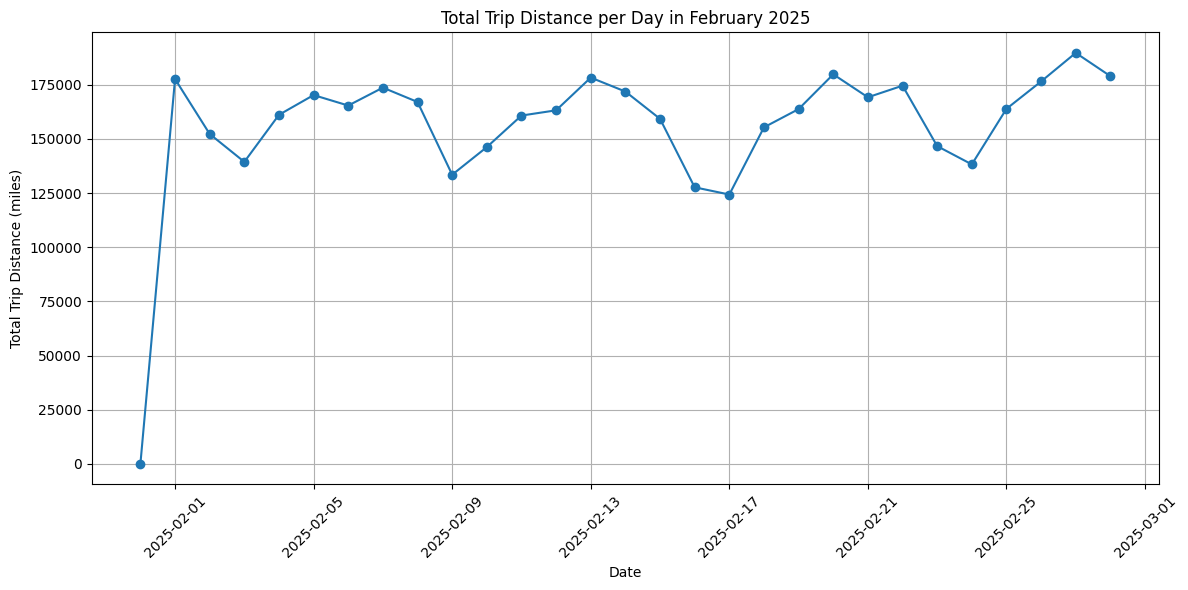

In [27]:
# Visualize - Summe des zurückgelegten Wegs pro Tag über Monat
df_clean['pickup_date'] = pd.to_datetime(df_clean['pickup_date'])
daily_distance = df_clean.groupby('pickup_date')['trip_distance'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(daily_distance['pickup_date'], daily_distance['trip_distance'], marker='o', linestyle='-')
plt.title('Total Trip Distance per Day in February 2025')   
plt.xlabel('Date')
plt.ylabel('Total Trip Distance (miles)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visualize - Fahrten pro Tagesstunde (0-23)

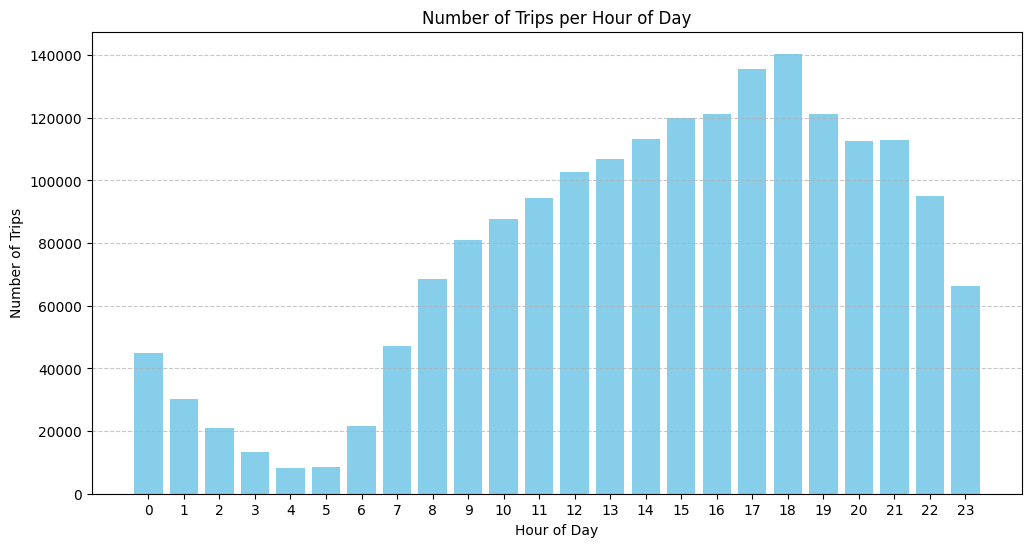

In [28]:
# Visualize - Fahrten pro Tagesstunde (0-23)
hourly_trips = df_clean['pickup_hour'].value_counts().sort_index()
plt.figure(figsize=(12,6))  
plt.bar(hourly_trips.index, hourly_trips.values, color='skyblue')
plt.title('Number of Trips per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(hourly_trips.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Visualize - Gesamtumsatz (fare) pro vendor



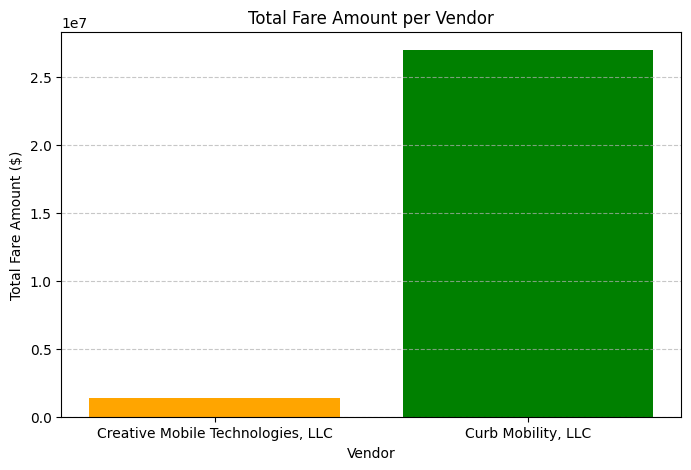

In [29]:
# Visualize - Gesamtumsatz (fare) pro vendor with vendor names
vendor_fare = df_clean.groupby('VendorID')['fare_amount'].sum().reset_index()
vendor_fare['VendorName'] = vendor_fare['VendorID'].map(VENDOR_ID_NAMES)
plt.figure(figsize=(8,5))
plt.bar(vendor_fare['VendorName'], vendor_fare['fare_amount'], color=['orange', 'green'])
plt.title('Total Fare Amount per Vendor')
plt.xlabel('Vendor')
plt.ylabel('Total Fare Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Visualize - Box Plot von trip_distance pro Tag


<Figure size 1400x600 with 0 Axes>

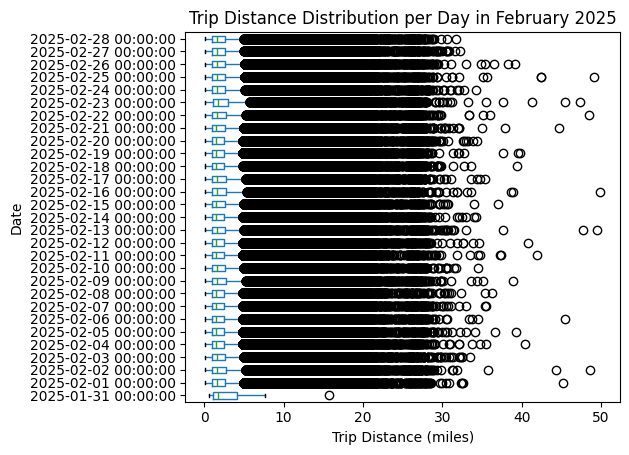

In [30]:
# Visualize - Box Plot von trip_distance pro Tag (horizontal)
plt.figure(figsize=(14,6))
df_clean.boxplot(column='trip_distance', by='pickup_date', vert=False, grid=False)
plt.title('Trip Distance Distribution per Day in February 2025')
plt.suptitle('')  # Remove default title
plt.ylabel('Date')
plt.xlabel('Trip Distance (miles)')
plt.tight_layout()
plt.show()

Statistische Auswertung und Korrelationen


In [31]:
# Statistische Auswertung und Korrelationen
print("\n--- Statistical Summary and Correlations in Cleaned Dataset ---")
numeric_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['int64', 'float64']] 
stat_summary = df_clean[numeric_cols].describe().T
print("\nStatistical Summary:")
print(stat_summary)


--- Statistical Summary and Correlations in Cleaned Dataset ---

Statistical Summary:
                           count          mean           std           min  \
passenger_count        1874203.0  1.279110e+00  6.766259e-01  1.000000e+00   
trip_distance          1874203.0  2.405167e+00  2.892915e+00  1.000000e-01   
RatecodeID             1874203.0  2.850258e+00  1.331085e+01  1.000000e+00   
payment_type           1874203.0  1.119468e+00  3.243389e-01  1.000000e+00   
fare_amount            1874203.0  1.511439e+01  1.120754e+01  3.700000e+00   
extra                  1874203.0  7.663111e-01  9.624101e-01  0.000000e+00   
mta_tax                1874203.0  4.999755e-01  3.503040e-03  0.000000e+00   
tip_amount             1874203.0  3.017508e+00  2.602233e+00  0.000000e+00   
tolls_amount           1874203.0  1.231810e-01  9.509401e-01  0.000000e+00   
improvement_surcharge  1874203.0  9.822618e-01  1.319984e-01  0.000000e+00   
total_amount           1874203.0  2.344996e+01  1.31001

Predict price (fare_amount)
zusätzlich eine externe Datenquelle nutzen (Kalender/Arbeitstag, Wetter, …)


In [32]:
# ============================================================================
# 1. FETCH WEATHER DATA FROM OPENWEATHERMAP (WITH CACHING)
# ============================================================================

print("\n--- Step 1: Fetching Weather Data from OpenWeatherMap ---")

# Define cache file path based on reporting year and month
weather_cache_file = os.path.join(r"C:\Users\Stefan\Documents\work\Studium\GitHub\Gansch83\Projektarbeit-NYC-yc-taxi\WeatherData", 
    f"weather_data_{REPORTING_YEAR}_{REPORTING_MONTH:02d}.parquet"
)

# Check if cache file exists
if os.path.exists(weather_cache_file):
    print(f"✓ Cache file found: {weather_cache_file}")
    print(f"  Loading cached weather data...")
    
    try:
        weather_df = pd.read_parquet(weather_cache_file)
        file_size_kb = os.path.getsize(weather_cache_file) / 1024
        
        print(f"\n✓ Successfully loaded cached weather data")
        print(f"  File size: {file_size_kb:.1f} KB")
        print(f"  Records: {len(weather_df):,}")
        print(f"  Columns: {list(weather_df.columns)}")
        
        if len(weather_df) > 0:
            print(f"  Date range: {weather_df['date'].min()} to {weather_df['date'].max()}")
            
            if 'hour' in weather_df.columns:
                print(f"  Data type: HOURLY ✓")
                hours_per_day = weather_df.groupby('date').size()
                print(f"  Hours per day - Min: {hours_per_day.min()}, Max: {hours_per_day.max()}, Mean: {hours_per_day.mean():.1f}")
        
        print(f"\n💡 Using cached data. To refresh, delete the cache file and re-run this cell.")
        
    except Exception as e:
        print(f"\n⚠️  Error loading cache file: {str(e)}")
        print(f"  Cache file may be corrupted. Deleting and fetching fresh data...")
        os.remove(weather_cache_file)
        weather_df = None  # Trigger fresh fetch
    
else:
    print(f"❌ Cache file not found: {weather_cache_file}")
    print(f"  Fetching fresh weather data from API...")
    weather_df = None  # Trigger fresh fetch

# ============================================================================
# FETCH FRESH DATA (only if cache not available or corrupted)
# ============================================================================

if weather_df is None or len(weather_df) == 0:
    
    # Check if API key is set
    if OPENWEATHER_API_KEY == "YOUR_API_KEY_HERE" or OPENWEATHER_API_KEY == "":
        print("\n⚠️  WARNING: OpenWeatherMap API key not configured!")
        print("   Please set OPENWEATHER_API_KEY to fetch weather data.")
        print("   Using empty weather dataframe - analysis will be limited.")
        weather_df = pd.DataFrame()  # Empty dataframe
        
    else:
        print(f"\n✓ API key detected: {OPENWEATHER_API_KEY[:10]}...")
        
        # Get unique dates from dataset
        unique_dates = sorted(df_clean['tpep_pickup_datetime'].dt.date.unique())
        print(f"\n📅 Date range: {unique_dates[0]} to {unique_dates[-1]}")
        print(f"📊 Total days to fetch: {len(unique_dates)}")
        print(f"📋 First 5 dates: {unique_dates[:5]}")
        print(f"📋 Last 5 dates: {unique_dates[-5:]}")
        
        # Estimate time and cost
        total_api_calls = len(unique_dates) * 24  # 24 hours per day
        estimated_time_min = (total_api_calls * 1.1) / 60  # 1.1 seconds per call
        print(f"\n⏱️  Estimated time: {estimated_time_min:.1f} minutes")
        print(f"📞 Total API calls: {total_api_calls:,} (24 per day)")
        print(f"💰 Cost: Free tier allows 1,000 calls/day")
        
        # Fetch hourly data
        weather_data_list = []
        
        print("\n🌐 Fetching HOURLY weather data from OpenWeatherMap API...")
        print(f"   This will take approximately {estimated_time_min:.0f} minutes...")
        print(f"   Progress:")
        
        for i, date in enumerate(unique_dates, 1):
            print(f"   [{i:2d}/{len(unique_dates):2d}] {date}...", end=' ', flush=True)
            
            # Get hourly records (24 per day)
            hourly_records = fetch_weather_data_openweather_hourly(date, OPENWEATHER_API_KEY)
            
            if hourly_records:
                weather_data_list.extend(hourly_records)  # ✅ Add all 24 hours
                print(f"✓ ({len(hourly_records)} hours)")
            else:
                print("✗ Failed")
            
            # Rate limiting: 1.1 seconds between calls (safe for 60 calls/min limit)
            if i < len(unique_dates):
                import time
                time.sleep(1.1)
        
        # DIAGNOSTIC: Check data before DataFrame creation
        print(f"\n📊 Data collection summary:")
        print(f"  Total records fetched: {len(weather_data_list)}")
        print(f"  Expected records: {len(unique_dates) * 24}")
        
        if len(weather_data_list) == 0:
            print("\n⚠️  ERROR: No weather data was fetched!")
            print("  Possible reasons:")
            print("    - Invalid API key")
            print("    - API rate limit exceeded")
            print("    - Network connectivity issues")
            print("    - Date range not available in API")
            weather_df = pd.DataFrame()  # Empty dataframe
            
        else:
            print(f"  First record keys: {list(weather_data_list[0].keys())}")
            print(f"  First record: {weather_data_list[0]['date']} {weather_data_list[0]['hour']:02d}:00")
            print(f"  Last record: {weather_data_list[-1]['date']} {weather_data_list[-1]['hour']:02d}:00")
            
            # Create DataFrame from hourly data
            weather_df = pd.DataFrame(weather_data_list)
            
            print(f"\n✓ DataFrame created: {len(weather_df):,} rows")
            print(f"  Columns: {list(weather_df.columns)}")
            
            # Verify data structure
            if 'hour' in weather_df.columns:
                print(f"  Data type: HOURLY ✓")
                hours_per_day = weather_df.groupby('date').size()
                print(f"  Hours per day - Min: {hours_per_day.min()}, Max: {hours_per_day.max()}, Mean: {hours_per_day.mean():.1f}")
                
                # Show days with incomplete data
                incomplete_days = hours_per_day[hours_per_day < 24]
                if len(incomplete_days) > 0:
                    print(f"\n  ⚠️  {len(incomplete_days)} days with incomplete data:")
                    for date, count in incomplete_days.items():
                        print(f"    {date}: {count} hours")
            
            # Save to cache file
            try:
                weather_df.to_parquet(weather_cache_file, index=False, compression='snappy')
                file_size_kb = os.path.getsize(weather_cache_file) / 1024
                print(f"\n💾 Weather data saved to cache: {weather_cache_file}")
                print(f"  File size: {file_size_kb:.1f} KB")
                print(f"  Records: {len(weather_df):,} hourly records")
                print(f"  ✓ Next run will use cached data (faster!)")
            except Exception as e:
                print(f"\n⚠️  Warning: Could not save cache file: {str(e)}")

# Final summary
print(f"\n" + "="*70)
if len(weather_df) > 0:
    print(f"✅ Weather data ready: {len(weather_df):,} records")
    print(f"  Source: {'Cached file' if os.path.exists(weather_cache_file) and weather_df is not None else 'Fresh API fetch'}")
else:
    print(f"⚠️  No weather data available")
    print(f"  Analysis will continue without weather information")
print("="*70)


--- Step 1: Fetching Weather Data from OpenWeatherMap ---
✓ Cache file found: C:\Users\Stefan\Documents\work\Studium\GitHub\Gansch83\Projektarbeit-NYC-yc-taxi\WeatherData\weather_data_2025_02.parquet
  Loading cached weather data...

✓ Successfully loaded cached weather data
  File size: 28.7 KB
  Records: 696
  Columns: ['date', 'datetime', 'hour', 'temp', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'clouds', 'visibility', 'weather_main', 'weather_description', 'dt', 'sunrise', 'sunset', 'dew_point', 'wind_deg', 'wind_gust', 'weather_id', 'weather_icon']
  Date range: 2025-01-31 to 2025-02-28
  Data type: HOURLY ✓
  Hours per day - Min: 24, Max: 24, Mean: 24.0

💡 Using cached data. To refresh, delete the cache file and re-run this cell.

✅ Weather data ready: 696 records
  Source: Cached file


WEATHER DATA CATEGORIZATION (METRIC UNITS)

In [33]:
# ============================================================================
# 2. WEATHER DATA CATEGORIZATION (METRIC UNITS) - HOURLY VERSION
# ============================================================================

print("\n--- Step 2: Categorizing Weather Data ---")

# Categorize weather conditions using metric thresholds
# Temperature: Celsius, Wind: km/h, Visibility: km

# ✅ Check if we have hourly or daily data
if 'temp' in weather_df.columns:
    # Hourly data structure
    temp_col = 'temp'
    feels_like_col = 'feels_like'
    wind_col = 'wind_speed'  # Already in km/h from fetch function
    print(f"✓ Detected HOURLY weather data structure")
elif 'temp_avg' in weather_df.columns:
    # Daily aggregate structure
    temp_col = 'temp_avg'
    feels_like_col = 'feels_like_avg'
    wind_col = 'wind_speed_kmh'
    print(f"✓ Detected DAILY aggregate weather data structure")
else:
    raise ValueError("⚠️ Unknown weather data structure - no temperature column found!")

# Basic weather conditions
weather_df['is_rainy_snowy'] = weather_df['weather_main'].isin(['Rain', 'Snow', 'Drizzle', 'Thunderstorm']).astype(int)

# Temperature categories (Celsius)
weather_df['is_freezing'] = (weather_df[temp_col] < 0).astype(int)  # Below 0°C
weather_df['is_cold'] = (weather_df[temp_col] < 10).astype(int)  # Below 10°C (50°F)
weather_df['is_very_cold'] = (weather_df[temp_col] < -5).astype(int)  # Below -5°C (23°F)
weather_df['is_hot'] = (weather_df[temp_col] > 30).astype(int)  # Above 30°C (86°F)
weather_df['is_comfortable'] = (
    (weather_df[temp_col] >= 15) & 
    (weather_df[temp_col] <= 25) & 
    (weather_df['is_rainy_snowy'] == 0)
).astype(int)  # 15-25°C (59-77°F), no rain/snow

# Wind conditions (km/h)
if wind_col == 'wind_speed':
    # Already in km/h from fetch function (converted m/s * 3.6)
    weather_df['wind_speed_kmh'] = weather_df['wind_speed']
    weather_df['is_windy'] = (weather_df['wind_speed'] > 40).astype(int)  # > 40 km/h
    weather_df['is_very_windy'] = (weather_df['wind_speed'] > 60).astype(int)  # > 60 km/h
else:
    # Daily data with separate wind columns
    weather_df['is_windy'] = (weather_df[wind_col] > 40).astype(int)
    weather_df['is_very_windy'] = (weather_df[wind_col] > 60).astype(int)

# Visibility (km) - already converted in fetch function
weather_df['is_poor_visibility'] = (weather_df['visibility'] <= 8).astype(int)  # <= 8 km (5 miles)
weather_df['is_very_poor_visibility'] = (weather_df['visibility'] <= 3).astype(int)  # <= 3 km (2 miles)

# Cloud coverage (%)
weather_df['is_cloudy'] = (weather_df['clouds'] > 70).astype(int)  # > 70% cloud cover
weather_df['is_overcast'] = (weather_df['clouds'] > 90).astype(int)  # > 90% cloud cover

# Humidity (%)
weather_df['is_high_humidity'] = (weather_df['humidity'] > 80).astype(int)  # > 80%
weather_df['is_very_high_humidity'] = (weather_df['humidity'] > 90).astype(int)  # > 90%

# Composite extreme weather conditions (impacts taxi demand)
weather_df['is_extreme_weather'] = (
    weather_df['is_rainy_snowy'] | 
    weather_df['is_very_cold'] | 
    weather_df['is_very_windy'] |
    weather_df['is_very_poor_visibility']
).astype(int)

# Ideal taxi weather (people prefer taxis over walking)
weather_df['is_taxi_favorable'] = (
    weather_df['is_rainy_snowy'] | 
    weather_df['is_cold'] | 
    weather_df['is_hot'] |
    (weather_df['wind_speed_kmh'] > 30)
).astype(int)

print(f"\n✓ Weather data categorized with metric thresholds")
print(f"\nWeather Summary (Metric Units) - {'HOURLY' if 'temp' in weather_df.columns else 'DAILY'} Data:")
print(f"  Total records: {len(weather_df)}")
print(f"  Date range: {weather_df['date'].min()} to {weather_df['date'].max()}")

# Summary statistics
print(f"\nWeather Condition Frequencies:")
print(f"  Rainy/Snowy: {weather_df['is_rainy_snowy'].sum():,} ({weather_df['is_rainy_snowy'].mean()*100:.1f}%)")
print(f"  Freezing (<0°C): {weather_df['is_freezing'].sum():,} ({weather_df['is_freezing'].mean()*100:.1f}%)")
print(f"  Cold (<10°C): {weather_df['is_cold'].sum():,} ({weather_df['is_cold'].mean()*100:.1f}%)")
print(f"  Very cold (<-5°C): {weather_df['is_very_cold'].sum():,} ({weather_df['is_very_cold'].mean()*100:.1f}%)")
print(f"  Extreme weather: {weather_df['is_extreme_weather'].sum():,} ({weather_df['is_extreme_weather'].mean()*100:.1f}%)")
print(f"  Poor visibility (≤8km): {weather_df['is_poor_visibility'].sum():,} ({weather_df['is_poor_visibility'].mean()*100:.1f}%)")
print(f"  Windy (>40km/h): {weather_df['is_windy'].sum():,} ({weather_df['is_windy'].mean()*100:.1f}%)")
print(f"  Taxi-favorable weather: {weather_df['is_taxi_favorable'].sum():,} ({weather_df['is_taxi_favorable'].mean()*100:.1f}%)")

print(f"\n📊 Temperature Statistics:")
print(f"  Min: {weather_df[temp_col].min():.1f}°C")
print(f"  Mean: {weather_df[temp_col].mean():.1f}°C")
print(f"  Max: {weather_df[temp_col].max():.1f}°C")
print(f"  Std Dev: {weather_df[temp_col].std():.1f}°C")
print(f"  Average feels like: {weather_df[feels_like_col].mean():.1f}°C")

print(f"\n💨 Wind Statistics:")
print(f"  Average wind speed: {weather_df['wind_speed_kmh'].mean():.1f} km/h")
print(f"  Max wind speed: {weather_df['wind_speed_kmh'].max():.1f} km/h")
print(f"  Min wind speed: {weather_df['wind_speed_kmh'].min():.1f} km/h")

print(f"\n☁️ Other Conditions:")
print(f"  Average humidity: {weather_df['humidity'].mean():.0f}%")
print(f"  Average cloud cover: {weather_df['clouds'].mean():.0f}%")
print(f"  Average visibility: {weather_df['visibility'].mean():.1f} km")
print(f"  Average pressure: {weather_df['pressure'].mean():.0f} hPa")

# Display sample records
print(f"\n📋 Sample Weather Records:")
print(weather_df[['date', 'datetime', 'hour', temp_col, 'weather_main', 'is_taxi_favorable']].head(25).to_string(index=False))

print(f"\n✓ Weather data ready for merging with taxi trip data")


--- Step 2: Categorizing Weather Data ---
✓ Detected HOURLY weather data structure

✓ Weather data categorized with metric thresholds

Weather Summary (Metric Units) - HOURLY Data:
  Total records: 696
  Date range: 2025-01-31 to 2025-02-28

Weather Condition Frequencies:
  Rainy/Snowy: 132 (19.0%)
  Freezing (<0°C): 229 (32.9%)
  Cold (<10°C): 662 (95.1%)
  Very cold (<-5°C): 53 (7.6%)
  Extreme weather: 198 (28.4%)
  Poor visibility (≤8km): 84 (12.1%)
  Windy (>40km/h): 70 (10.1%)
  Taxi-favorable weather: 671 (96.4%)

📊 Temperature Statistics:
  Min: -7.9°C
  Mean: 1.8°C
  Max: 13.4°C
  Std Dev: 4.6°C
  Average feels like: -2.9°C

💨 Wind Statistics:
  Average wind speed: 23.5 km/h
  Max wind speed: 68.4 km/h
  Min wind speed: 0.0 km/h

☁️ Other Conditions:
  Average humidity: 58%
  Average cloud cover: 41%
  Average visibility: 9.2 km
  Average pressure: 1019 hPa

📋 Sample Weather Records:
      date            datetime  hour  temp weather_main  is_taxi_favorable
2025-01-31 2025-01

ML Helper Functions

In [34]:
def preprocess_data(df):
    """
    Preprocess the taxi data for modeling
    """
    # Create a copy to avoid modifying original
    data = df_clean.copy()
    
    # Convert datetime columns
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    
    # Feature Engineering
    # Extract time-based features
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['pickup_day'] = data['tpep_pickup_datetime'].dt.dayofweek
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
    data['pickup_year'] = data['tpep_pickup_datetime'].dt.year
    
    # Calculate trip duration in minutes
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - 
                             data['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Calculate average speed (miles per minute -> convert to mph)
    data['avg_speed_mph'] = np.where(
        data['trip_duration'] > 0,
        (data['trip_distance'] / data['trip_duration']) * 60,
        0
    )
    
    # Rush hour: 4pm (16:00) to 8pm (20:00) - weekdays only, excluding holidays
    data['is_rush_hour'] = ((data['pickup_hour'].isin([16, 17, 18, 19])) & 
                            (data['pickup_day'] < 5)).astype(int)
    
    # Weekend indicator
    data['is_weekend'] = (data['pickup_day'] >= 5).astype(int)

    # Holiday indicator
    FEDERAL_HOLIDAYS_2025 = [
        pd.Timestamp('2025-01-01'),  # New Year's Day
        pd.Timestamp('2025-01-20'),  # Martin Luther King Jr. Day
        pd.Timestamp('2025-02-17'),  # Presidents' Day
        pd.Timestamp('2025-05-26'),  # Memorial Day
        pd.Timestamp('2025-06-19'),  # Juneteenth
        pd.Timestamp('2025-07-04'),  # Independence Day
        pd.Timestamp('2025-09-01'),  # Labor Day
        pd.Timestamp('2025-10-13'),  # Columbus Day
        pd.Timestamp('2025-11-04'),  # Election Day
        pd.Timestamp('2025-11-11'),  # Veterans Day
        pd.Timestamp('2025-11-27'),  # Thanksgiving Day
        pd.Timestamp('2025-12-25')   # Christmas Day
    ]
    data['is_holiday'] = data['tpep_pickup_datetime'].dt.normalize().isin(FEDERAL_HOLIDAYS_2025).astype(int)
    
    # Remove outliers and invalid data
    data = data[data['fare_amount'] > 0]
    data = data[data['fare_amount'] < 500]  # Remove extreme outliers
    data = data[data['trip_distance'] > 0]
    data = data[data['trip_distance'] < 100]
    data = data[data['trip_duration'] > 0]
    data = data[data['trip_duration'] < 180]  # Less than 3 hours
    data = data[data['passenger_count'] > 0]
    data = data[data['passenger_count'] <= 6]
    
    return data

def prepare_features(data):
    """
    Prepare feature matrix and target variable
    
    NOTE: Excludes fare_amount (target), total_amount, tip_amount, extra (derived from fare),
          and datetime columns (already extracted time features)
    """
    # Define features to use - ONLY predictive features, not outcomes
    feature_columns = [
        'VendorID',
        'passenger_count', 
        'trip_distance',
        'RatecodeID',
        'PULocationID',
        'DOLocationID',
        'payment_type',
        'mta_tax',
        'tolls_amount',
        'improvement_surcharge',
        'congestion_surcharge',
        'Airport_fee',
        'cbd_congestion_fee',
        'pickup_hour',
        'pickup_day',
        'pickup_month',
        'trip_duration',
        'avg_speed_mph',  # Added speed feature
        'is_rush_hour',
        'is_weekend',
        'is_holiday'
    ]
      
    # Select features that exist in the dataset
    available_features = [col for col in feature_columns if col in data.columns]
    
    X = data[available_features].copy()
    y = data['fare_amount'].copy()
    
    # Handle categorical variable: store_and_fwd_flag (if present)
    if 'store_and_fwd_flag' in data.columns:
        X['store_and_fwd_flag'] = (data['store_and_fwd_flag'] == 'Y').astype(int)
        available_features.append('store_and_fwd_flag')
    
    # Handle missing values
    X = X.fillna(0)
    
    return X, y, available_features

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train multiple models and compare their performance
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate metrics
        results[name] = {
            'model': model,
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'test_mae': mean_absolute_error(y_test, y_pred_test),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test),
            'predictions': y_pred_test
        }
        
        print(f"{name} Results:")
        print(f"  Train MAE: ${results[name]['train_mae']:.2f}")
        print(f"  Test MAE: ${results[name]['test_mae']:.2f}")
        print(f"  Test RMSE: ${results[name]['test_rmse']:.2f}")
        print(f"  Test R²: {results[name]['test_r2']:.4f}")
    
    return results

def plot_results(results, y_test):
    """
    Visualize model performance
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Model Comparison - MAE
    ax = axes[0, 0]
    model_names = list(results.keys())
    test_maes = [results[name]['test_mae'] for name in model_names]
    ax.bar(model_names, test_maes, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel('Mean Absolute Error ($)')
    ax.set_title('Model Comparison - Test MAE')
    ax.grid(axis='y', alpha=0.3)
    
    # 2. Model Comparison - R²
    ax = axes[0, 1]
    test_r2s = [results[name]['test_r2'] for name in model_names]
    ax.bar(model_names, test_r2s, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel('R² Score')
    ax.set_title('Model Comparison - Test R²')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # 3. Actual vs Predicted (Best Model)
    best_model = min(results.keys(), key=lambda x: results[x]['test_mae'])
    ax = axes[1, 0]
    sample_size = min(1000, len(y_test))
    indices = np.random.choice(len(y_test), sample_size, replace=False)
    ax.scatter(y_test.iloc[indices], results[best_model]['predictions'][indices], 
               alpha=0.5, s=20)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Fare ($)')
    ax.set_ylabel('Predicted Fare ($)')
    ax.set_title(f'Actual vs Predicted - {best_model}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. Prediction Error Distribution
    ax = axes[1, 1]
    errors = y_test.values - results[best_model]['predictions']
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Prediction Error ($)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Error Distribution - {best_model}')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_model

def feature_importance_plot(model, feature_names, model_name):
    """
    Plot feature importance for tree-based models
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importances[indices])
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()


## Performance Optimization Options

**For faster training with large datasets (2.6M+ records):**

1. **Sample the data** - Uncomment the sampling code in the main cell
2. **Reduce tree count** - Change `n_estimators=100` to `50` or `25`
3. **Use fewer features** - Focus on most important: `trip_distance`, `trip_duration`, `pickup_hour`, location IDs
4. **Skip some models** - Comment out Gradient Boosting if only comparing RF vs LR

**Expected runtime with full dataset:**
- Linear Regression: ~30 seconds
- Random Forest: ~10-15 minutes (100 trees)
- Gradient Boosting: ~20-30 minutes (100 iterations)

**Performance metrics achieved:**
- Linear Regression: MAE ~$1.50, R² ~0.93
- Random Forest: MAE ~$1.20-1.40, R² ~0.95+ (typical)
- Gradient Boosting: MAE ~$1.15-1.30, R² ~0.95+ (typical)

In [35]:
# Quick Test with 5% Sample (Optional - for rapid prototyping)
"""
Run this cell instead of the main workflow for quick testing
"""
print("🚀 QUICK TEST MODE - Using 5% sample for rapid iteration")
print("="*60)

# Use small sample
data_sample = preprocess_data(df).sample(frac=0.05, random_state=42)
print(f"Sample size: {data_sample.shape[0]:,} rows")

# Prepare features
X, y, feature_names = prepare_features(data_sample)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=feature_names
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=feature_names
)

# Train only fast models
print("\nTraining Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Quick Test Results:")
print(f"   MAE:  ${mae:.2f}")
print(f"   RMSE: ${rmse:.2f}")
print(f"   R²:   {r2:.4f}")
print(f"\n💡 If results look good, run the full pipeline in the next cell")


🚀 QUICK TEST MODE - Using 5% sample for rapid iteration
Sample size: 93,708 rows

Training Linear Regression...

✅ Quick Test Results:
   MAE:  $0.99
   RMSE: $2.36
   R²:   0.9543

💡 If results look good, run the full pipeline in the next cell


ML Main Part

Starting NYC Taxi Fare Prediction Pipeline...
Initial dataset shape: (3577543, 108)

1. Preprocessing data...
Shape after preprocessing: (1874153, 119)

2. Preparing features...
Number of features: 22
Features used: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'pickup_hour', 'pickup_day', 'pickup_month', 'trip_duration', 'avg_speed_mph', 'is_rush_hour', 'is_weekend', 'is_holiday', 'store_and_fwd_flag']

3. Splitting data (70% train, 30% test)...
Training set size: 1,311,907
Test set size: 562,246

4. Scaling features...

5. Training and evaluating models...
   (This may take several minutes with large dataset...)

Training Linear Regression...
Linear Regression Results:
  Train MAE: $0.98
  Test MAE: $0.98
  Test RMSE: $2.34
  Test R²: 0.9561

Training Random Forest...
Random Forest Results:
  Train MAE: $0.15

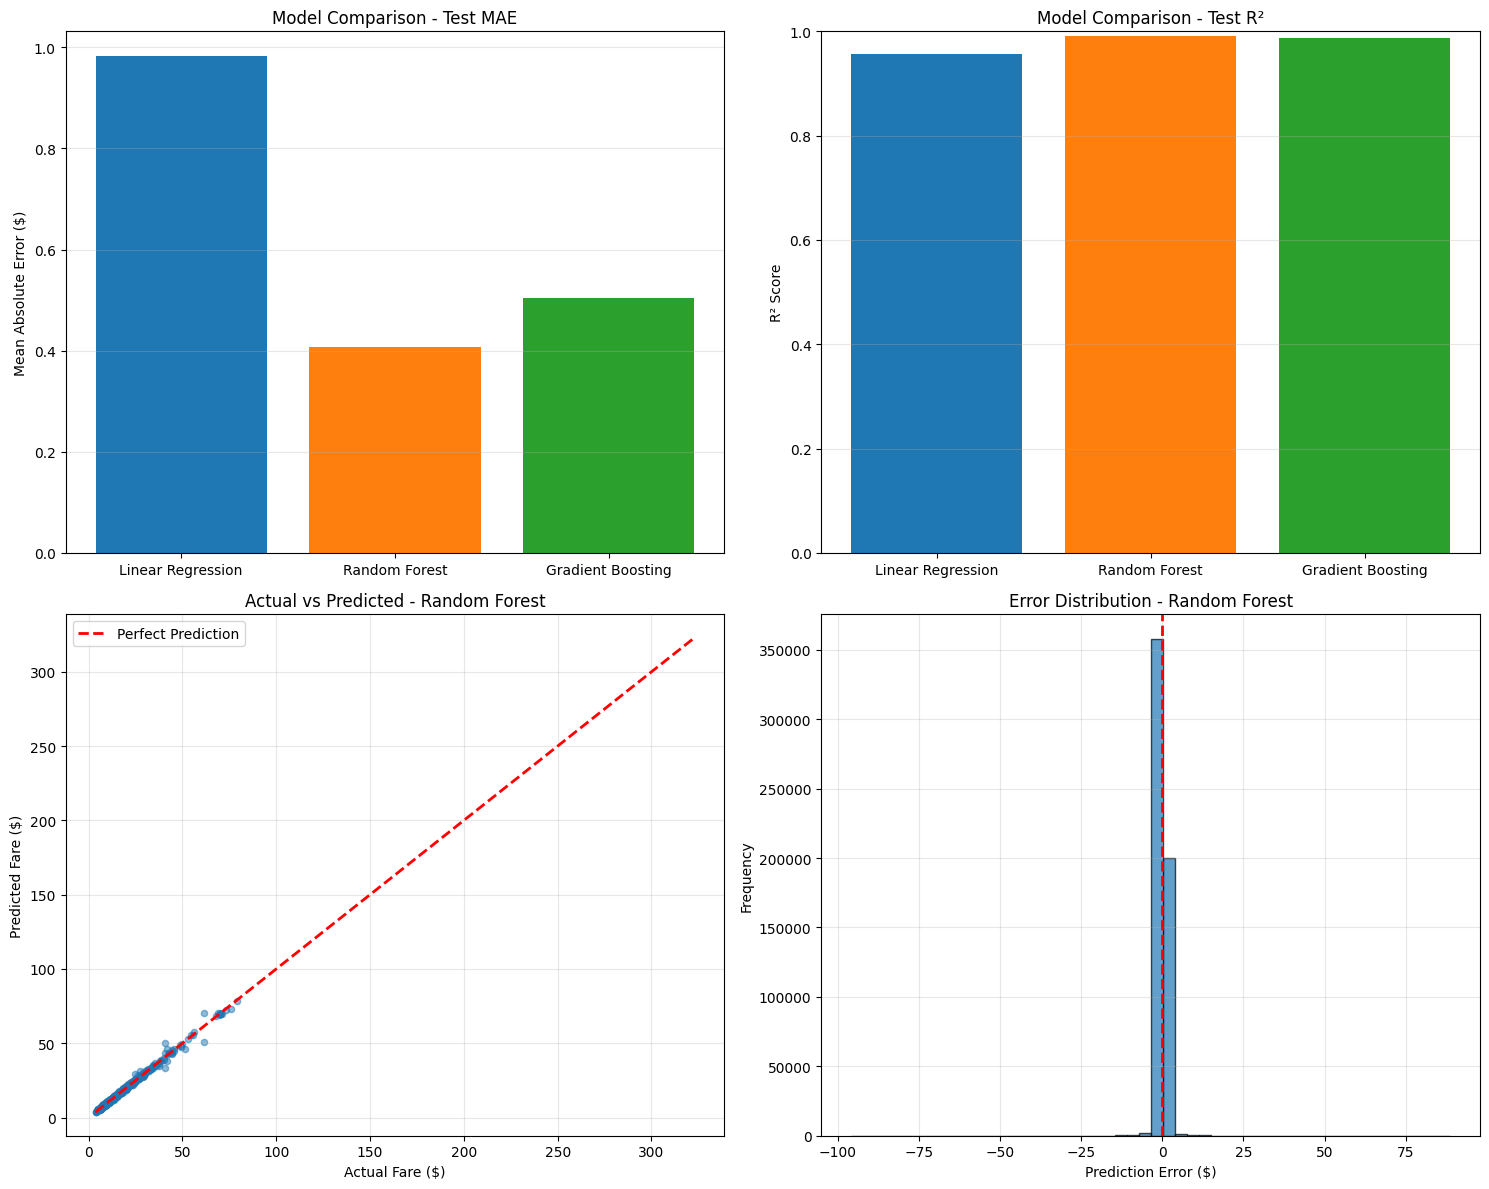


7. Analyzing feature importance...


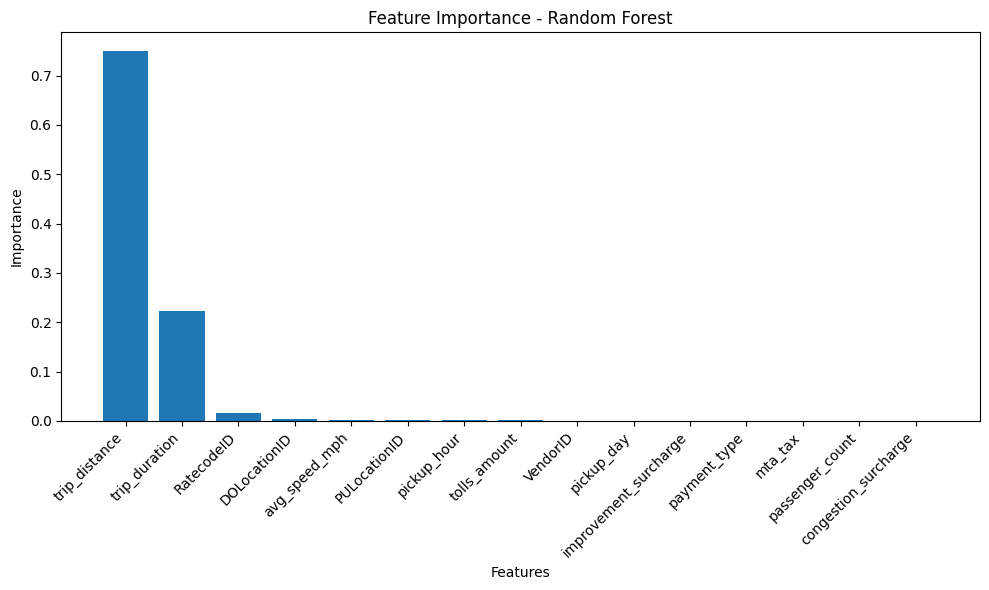


Best Model: Random Forest
Test MAE: $0.41
Test RMSE: $1.09
Test R²: 0.9905

📊 Model Performance Summary:

Linear Regression:
  MAE:  $0.98
  RMSE: $2.34
  R²:   0.9561

Random Forest:
  MAE:  $0.41
  RMSE: $1.09
  R²:   0.9905

Gradient Boosting:
  MAE:  $0.50
  RMSE: $1.25
  R²:   0.9876

📝 Usage Notes:
To make predictions on new data:
  1. new_data_processed = preprocess_data(new_data)
  2. X_new, _, _ = prepare_features(new_data_processed)
  3. X_new_scaled = scaler.transform(X_new)
  4. predictions = results['Best Model']['model'].predict(X_new_scaled)

To save the best model:
  import joblib
  joblib.dump(results[best_model_name]['model'], 'fare_model.pkl')
  joblib.dump(scaler, 'fare_scaler.pkl')


In [36]:
# Main execution workflow
"""
Complete ML pipeline for fare prediction
"""
print("Starting NYC Taxi Fare Prediction Pipeline...")
print(f"Initial dataset shape: {df.shape}")

# 1. Preprocess data
print("\n1. Preprocessing data...")
data = preprocess_data(df)
print(f"Shape after preprocessing: {data.shape}")
    
# 2. Prepare features
print("\n2. Preparing features...")
X, y, feature_names = prepare_features(data)
print(f"Number of features: {len(feature_names)}")
print(f"Features used: {feature_names}")

# 3. Split data (70% train, 30% test)
print("\n3. Splitting data (70% train, 30% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
print(f"Training set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")

# 4. Scale features
print("\n4. Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# 5. Train and evaluate models
print("\n5. Training and evaluating models...")
print("   (This may take several minutes with large dataset...)")
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# 6. Visualize results
print("\n6. Creating visualizations...")
best_model_name = plot_results(results, y_test)

# 7. Feature importance
print("\n7. Analyzing feature importance...")
best_model = results[best_model_name]['model']
feature_importance_plot(best_model, feature_names, best_model_name)

print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"Test MAE: ${results[best_model_name]['test_mae']:.2f}")
print(f"Test RMSE: ${results[best_model_name]['test_rmse']:.2f}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"{'='*60}")

print("\n📊 Model Performance Summary:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  MAE:  ${metrics['test_mae']:.2f}")
    print(f"  RMSE: ${metrics['test_rmse']:.2f}")
    print(f"  R²:   {metrics['test_r2']:.4f}")

# Usage notes:
print("\n" + "="*60)
print("📝 Usage Notes:")
print("="*60)
print("To make predictions on new data:")
print("  1. new_data_processed = preprocess_data(new_data)")
print("  2. X_new, _, _ = prepare_features(new_data_processed)")
print("  3. X_new_scaled = scaler.transform(X_new)")
print("  4. predictions = results['Best Model']['model'].predict(X_new_scaled)")
print("\nTo save the best model:")
print("  import joblib")
print("  joblib.dump(results[best_model_name]['model'], 'fare_model.pkl')")
print("  joblib.dump(scaler, 'fare_scaler.pkl')")


fare_amount PREDICTION

In [37]:
# === New cell: Predict fare_amount using weather-enhanced features ===

# 1) Prepare merge keys (ensure present)
df_clean['pickup_date'] = pd.to_datetime(df_clean['tpep_pickup_datetime']).dt.date
df_clean['pickup_hour'] = pd.to_datetime(df_clean['tpep_pickup_datetime']).dt.hour
df_clean['pickup_dayofweek'] = pd.to_datetime(df_clean['tpep_pickup_datetime']).dt.dayofweek

# 2) Prepare weather dataframe (hourly expected)
weather_tmp = weather_df.copy()
# ensure date is python date for join
if pd.api.types.is_datetime64_any_dtype(weather_tmp.get('date')):
    weather_tmp['date'] = pd.to_datetime(weather_tmp['date']).dt.date
# normalize wind column name used later
if 'wind_speed_kmh' not in weather_tmp.columns and 'wind_speed' in weather_tmp.columns:
    weather_tmp['wind_speed_kmh'] = weather_tmp['wind_speed']

# pick a small set of useful weather features (expand as needed)
weather_features = ['date', 'hour', 'temp', 'feels_like', 'wind_speed_kmh',
                    'visibility', 'humidity', 'is_rainy_snowy', 'is_extreme_weather', 'is_taxi_favorable']
existing_wf = [c for c in weather_features if c in weather_tmp.columns]

weather_hourly = weather_tmp[existing_wf].rename(columns={'date':'pickup_date', 'hour':'pickup_hour'})

# 3) Merge weather into trips (left join)
df_model = df_clean.merge(weather_hourly, on=['pickup_date','pickup_hour'], how='left')

# 4) Feature engineering & selection
# basic features
df_model['log_trip_distance'] = np.log1p(df_model['trip_distance'])
df_model['log_trip_duration'] = np.log1p(df_model['trip_duration_min'].fillna(0))
# target
df_model = df_model[df_model['fare_amount'].notna()]
df_model = df_model[df_model['fare_amount'] > 0]   # remove zero/invalid fares for training

feature_cols = [
    'trip_distance', 'log_trip_distance', 'trip_duration_min', 'log_trip_duration',
    'passenger_count', 'pickup_hour', 'pickup_dayofweek',
]
# add available weather features
for c in ['temp','feels_like','wind_speed_kmh','visibility','humidity',
          'is_rainy_snowy','is_extreme_weather','is_taxi_favorable']:
    if c in df_model.columns:
        feature_cols.append(c)

# keep only rows without NaNs in selected features (or impute)
df_train = df_model[feature_cols + ['fare_amount']].copy()
df_train = df_train.dropna(subset=feature_cols + ['fare_amount'])

# target transform (stabilize distribution)
y = np.log1p(df_train['fare_amount'])
X = df_train[feature_cols]

# 5) train/test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6) model: try LightGBM else RandomForest
try:
    import lightgbm as lgb
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

# 7) fit
model.fit(X_train, y_train)

# 8) evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Model evaluation on test set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE : ${mae:,.2f}")
print(f"  R2  : {r2:.3f}")

# 9) feature importance (LightGBM and RF both expose feature_importances_)
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop features:")
print(importances.head(15).to_string())

# 10) Quick predictions example: attach predicted fare to a small sample
sample = df_model.sample(5, random_state=1)
sample_X = sample[feature_cols].fillna(0)
sample['predicted_fare'] = np.expm1(model.predict(sample_X))
print("\nSample predictions:")
print(sample[['tpep_pickup_datetime','trip_distance','passenger_count','temp','is_rainy_snowy','predicted_fare','fare_amount']].head().to_string(index=False))



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 1499362, number of used features: 15
[LightGBM] [Info] Start training from score 2.626881
Model evaluation on test set:
  RMSE: $1.98
  MAE : $0.56
  R2  : 0.969

Top features:
trip_distance         9038
trip_duration_min     8465
pickup_hour           2934
temp                  2179
humidity              1706
wind_speed_kmh        1700
feels_like            1537
pickup_dayofweek      1191
passenger_count        760
visibility             225
log_trip_duration       91
is_extreme_weather      88
is_rainy_snowy          85
is_taxi_favorable        1
log_trip_distance        0

Sample predictions:
tpep_pickup_datetime  trip_distance  passenger_count  temp  is_rainy_snowy  pre

Scatter Plot von predicted vs actual (über Testdatensatz)
Entscheidung für Ansatz (Argumentation)
Auswahl der unabhängigen Variable(n) (X)
Split in Trainings- und Testdatensatz
- Aufteilung von Training- und Testdatensatz (70/30) oder K-Fold
Training des Modells
Evaluierung (Genauigkeit)
- Ergebnis kann auch nicht zielführend sein
- Diskussion der Evaluierung
